In [1]:
def plot_top_conversion_rates(df, category_col, target_col, top_n=10):
    
    # 각 범주별로 target_col의 True와 False의 개수를 집계
    conversion_counts = df.groupby([category_col, target_col]).size().unstack(fill_value=0)

    # True 비율
    conversion_rates = conversion_counts.div(conversion_counts.sum(axis=1), axis=0)

    # True 비율이 높은 상위 N개 범주를 선택
    top_categories = conversion_rates[True].sort_values(ascending=False).head(top_n).index

    top_conversion_rates = conversion_rates.loc[top_categories]

    ax = top_conversion_rates.plot(kind='bar', stacked=True, figsize=(10, 5))

    plt.title(f'Top {top_n}')
    plt.xlabel(category_col)
    plt.ylabel('Conversion Rate')
    plt.xticks(rotation=45)
    plt.legend(title=target_col, labels=['False', 'True'])

    # 그래프 표시
    plt.tight_layout()
    plt.show()


# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier



from category_encoders import TargetEncoder


import seaborn as sns
import matplotlib.pyplot as plt

### 데이터 셋 읽어오기

In [3]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [4]:
df_train

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.00,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.00,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.00,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.00,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.00,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,1.00,/Sląskie/Poland,AS,NaN,33747,End Customer,SMB,NaN,NaN,NaN,...,LGEPL,3 months ~ 6 months,0,0,0.000026,0.028777,public facility,Others,694,False
59295,0.75,/Bogotá DC /Colombia,AS,0.040000,35420,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGECB,9 months ~ 1 year,0,0,0.000026,0.028777,public facility,NaN,39,False
59296,0.75,/Pisco/Peru,AS,0.040000,19249,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEPR,less than 3 months,0,0,0.000026,0.028777,public facility,NaN,125,False
59297,1.00,/santa cruz bolivia/Peru,AS,0.040000,40327,NaN,Enterprise,NaN,NaN,NaN,...,LGEPR,more than a year,0,0,0.000026,0.028777,public facility,NaN,134,False


## EDA

| Field                   | 설명                                                         |
| :---------------------- | :----------------------------------------------------------- |
| bant_submit             | MQL 구성 요소들 중 [1]Budget(예산), [2]Title(고객의 직책/직급), [3]Needs(요구사항), [4]Timeline(희망 납기일) 4가지 항목에 대해서 작성된 값의 비율 |
| customer_country        | 고객의 국적                                                  |
| business_unit           | MQL 요청 상품에 대응되는 사업부                              |
| com_reg_ver_win_rate    | Vertical Level 1, business unit, region을 기준으로 oppty 비율을 계산 |
| customer_idx            | 고객의 회사명                                                |
| customer_type           | 고객 유형                                                    |
| enterprise              | Global 기업인지, Small/Medium 규모의 기업인지                |
| historical_existing_cnt | 이전에 Converted(영업 전환) 되었던 횟수                      |
| id_strategic_ver        | (도메인 지식) 특정 사업부(Business Unit이 ID일 때), 특정 사업 영역(Vertical Level1)에 대해 가중치를 부여 |
| it_strategic_ver        | (도메인 지식) 특정 사업부(Business Unit이 IT일 때), 특정 사업 영역(Vertical Level1)에 대해 가중치를 부여 |
| idit_strategic_ver      | Id_strategic_ver이나 it_strategic_ver 값 중 하나라도 1의 값을 가지면 1 값으로 표현 |
| customer_job            | 고객의 직업군                                                |
| lead_desc_length        | 고객이 작성한 Lead Descriptoin 텍스트 총 길이                |
| inquiry_type            | 고객의 문의 유형                                             |
| product_category        | 요청 제품 카테고리                                           |
| product_subcategory     | 요청 제품 하위 카테고리                                      |
| product_modelname       | 요청 제품 모델명                                             |
| customer_country.1      | 담당 자사 법인명 기반의 지역 정보(대륙)                      |
| customer_position       | 고객의 회사 직책                                             |
| response_corporate      | 담당 자사 법인명                                             |
| expected_timeline       | 고객의 요청한 처리 일정                                      |
| ver_cus                 | 특정 Vertical Level 1(사업영역) 이면서 Customer_type(고객 유형)이 소비자(End-user)인 경우에 대한 가중치 |
| ver_pro                 | 특정 Vertical Level 1(사업영역) 이면서 특정 Product Category(제품 유형)인 경우에 대한 가중치 |
| ver_win_rate_x          | 전체 Lead 중에서 Vertical을 기준으로 Vertical 수 비율과 Vertical 별 Lead 수 대비 영업 전환 성공 비율 값을 곱한 값 |
| ver_win_ratio_per_bu    | 특정 Vertical Level1의 Business Unit 별 샘플 수 대비 영업 전환된 샘플 수의 비율을 계산 |
| business_area           | 고객의 사업 영역                                             |
| business_subarea        | 고객의 세부 사업 영역                                        |
| lead_owner              | 영업 담당자 이름                                             |
| is_converted            | 영업 성공 여부. True일 시 성공.                              |

In [5]:
print(df_train['bant_submit'].value_counts())
print(df_test['bant_submit'].value_counts())

bant_submit
0.50    17192
1.00    17061
0.25    12852
0.75    11681
0.00      513
Name: count, dtype: int64
bant_submit
1.00    2070
0.25    1522
0.50     667
0.75     545
0.00     467
Name: count, dtype: int64


In [6]:
print(df_train['bant_submit'].isnull().sum())
print(df_test['bant_submit'].isnull().sum())

0
0


고유값 : 0.00, 0.25, 0.50, 0.75, 1.00
결측치 : x

# 1. customer_country

In [7]:
df_train['customer_country'].isnull().sum()

982

In [8]:
df_train['customer_country.1'].isnull().sum()

982

In [9]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

similarity_score = similar(df_train['customer_country.1'].astype(str), df_train['customer_country'].astype(str))
print(f'유사도 확인 : {similarity_score:.2%}')


유사도 확인 : 100.00%


In [10]:
# customer_country.1과 유사도 판단 결과 100% 확인. 즉 customer_country.1 drop해야함.

In [11]:
df_train.drop('customer_country.1', axis=1, inplace=True)
df_test.drop('customer_country.1', axis=1, inplace=True)

In [12]:
import pandas as pd


def clean_customer_country(df):
    df_c = df['customer_country'].fillna('None')
    df_c = df_c.str.replace(pat='[ ]', repl='', regex=True).reset_index().drop('index', axis=1)

    
    c_list = df_c['customer_country'].str.split('/')
    result = [c[-1] for c in c_list]
    
  
    result_df = pd.DataFrame(result, columns=['customer_country'])

   
    replace_country = {
       'Manaus': 'Brazil',
    'Aparecida' : 'Brazil',
    'BR' : 'Brazil',
    'Dourados' : 'Brazil',
    'Cuiabá' : 'Brazil',
    'Recife' : 'Brazil',
    'SãoPaulo' : 'Brazil',
    'SaoPaulo' : 'Brazil',
    'JoãoPessoa' : 'Brazil',
    'Capãodacanoa' : 'Brazil',
    'BeloHorizonte' : 'Brazil',
    'SãoPaulo,Pinheiros' : 'Brazil',
    'CentrodeProduçãoAudiovisual-SescSãoPaulo' : 'Brazil',
    'FozdeIguaçu-PRAvenidaTancredoNeves6731JardimItaipu' : 'Brazil',
    'ViaE.DeAmicis,23.90044Carini(PA)' : 'Italy',
    'NewHampshire': 'UnitedStates',
    '1HoagDr.' : 'UnitedStates',
    '21903RanierLn' : 'UnitedStates',
    'JacksonvilleFlorida' : 'UnitedStates',
    'USVirginIslands' : 'UnitedStates',
    '3NassonAvenue' : 'UnitedStates',
    'Zip98433' : 'UnitedStates',
    'Nevada' : 'UnitedStates',
    'Ohio' : 'UnitedStates',
    'AnandViharDelhi' : 'India',
    'uttarpradesh' : 'India',
    'mumbai' : 'India',
    'Telangana' : 'India',
    'bangalore': 'India',
    'gujarat' : 'India',
    'gurgaon': 'India',
    'indore' : 'India',
    'kerela' : 'India',
    'Chennai' : 'India',
    'lucknow' : 'India',
    'Gujarat' : 'India',
    'Pune' : 'India',
    'odisha' : 'India',
    'hyderabad' : 'India',
    'bhilwara' : 'India',
    'CACERES' : 'Spain',
    'GRANCANARIASPLAYADELINGLES' : 'Spain',
    'VALENCIA' : 'Spain',
    'MADRID' : 'Spain',
    'SPAIN' : 'Spain',
    '1605Ave.PoncedeLeón,Suite400SanJuan,00909,PuertoRico' :'PuertoRico',
    'ΘέσηΠέτσαΒακαλοπούλουΒΙΟΠΑΠαλλήνης15351' : 'Greece',
    'Barranquilla' : 'Colombia',
    'Bucaramanga' : 'Colombia',
    'Cartagena' : 'Colombia',
    'COLOMBIA' : 'Colombia',
    'CARRERA11A94-46EDIFICIOCHICO3000PISO3BOGOTA' : 'Colombia',
    '1919MinnesotaCt,Mississauga,ONL5N' : 'Canada',
    'HaNoi' : 'Vietnam',
    'ARGENTINA' : 'Argentina',
    'EGYPT' : 'Egypt',
    'PerU' : 'Peru',
    'UAEDubai' : 'U.A.E',
    'Antigua' : 'AntiguaandBarbuda',
    'Dominicanrepublic' : 'DominicanRepublic',
    'NetherlandsAntilles' : 'Netherlands', 
    'A' : 'None',
    'country' : 'None',
    '':'None'
    }

    result_df['customer_country'] = result_df['customer_country'].replace(replace_country)

    result_df.loc[result_df['customer_country'].str.contains('UnitedStates'), 'customer_country'] = 'UnitedStates'
    result_df.loc[result_df['customer_country'].str.contains('Italy'), 'customer_country'] ='Italy'
    result_df.loc[result_df['customer_country'].str.contains('Colombia'), 'customer_country'] ='Colombia'
    result_df.loc[result_df['customer_country'].str.contains('ALICANTE'), 'customer_country'] ='Spain'

    result_df.loc[result_df['customer_country'].str.contains(r'^[A-Z]{2}$|[A-Z]{2}\d{5}$'), 'customer_country'] = 'UnitedStates'
    result_df.loc[result_df['customer_country'].str.contains(r'\b[A-Z]{2}\d{5}\b|USA'), 'customer_country'] = 'UnitedStates'
    result_df['customer_country'][(result_df['customer_country'].str.contains(r'\d{5}'))
                             & (~result_df['customer_country'].str.contains('@'))] = 'UnitedStates'
    result_df.loc[result_df['customer_country'].str.contains(r'\d{4}$|^\d{4}|^\d{3}'), 'customer_country'] = 'UnitedStates'

    result_df['customer_country'][result_df['customer_country'].str.contains('@')] = 'None'
    return result_df


df_train['customer_country'] = clean_customer_country(df_train)
df_test['customer_country'] = clean_customer_country(df_test)


In [13]:
df_train['customer_country'].unique()

array(['Philippines', 'India', 'Nigeria', 'SaudiArabia', 'Singapore',
       'Brazil', 'U.A.E', 'SouthAfrica', 'UnitedStates', 'Colombia',
       'Mexico', 'Ghana', 'Egypt', 'DemocraticRepublicoftheCongo',
       'Ethiopia', 'Australia', 'None', 'Kenya', 'Indonesia', 'Oman',
       'Pakistan', 'UnitedKingdom', 'Guatemala', 'Panama', 'Canada',
       'Bangladesh', 'PapuaNewGuinea', 'UnitedRepublicofTanzania',
       'Qatar', 'Afghanistan', 'Chile', 'Mozambique', 'Turkey', 'Türkiye',
       'ElSalvador', 'Togo', 'Jordan', 'Iraq', 'Israel', 'SriLanka',
       'SouthKorea', 'Portugal', 'Mauritania', 'Uruguay', 'Peru',
       'Germany', 'Romania', 'Norway', 'Jamaica', 'Hungary', 'Poland',
       'Czech', 'Spain', 'Argentina', 'Ecuador', 'Senegal', 'HongKong',
       'Malaysia', 'Japan', 'Kuwait', 'Ireland', 'Albania', 'Greece',
       'Algeria', 'Nicaragua', 'Slovenia', 'Italy', 'Netherlands',
       'DominicanRepublic', 'France', 'Uganda', 'Iran', 'Paraguay',
       'Bolivia', 'Namibia', '

In [14]:
value_counts_result = df_test['customer_country'].value_counts()
value_counts_result

customer_country
Brazil          1045
India            906
UnitedStates     780
Philippines      289
None             220
                ... 
Jamaica            1
Somalia            1
Israel             1
Kosovo             1
Pakistan           1
Name: count, Length: 92, dtype: int64

In [15]:
df_test['customer_country'].unique()

array(['Brazil', 'UnitedStates', 'U.A.E', 'Germany', 'Egypt', 'France',
       'None', 'UNITEDSTATES', 'Indonesia', 'India', 'Italy', 'Argentina',
       'Türkiye', 'SaudiArabia', 'Philippines', 'Peru', 'Vietnam',
       'Australia', 'Chile', 'Colombia', 'HongKong', 'Mexico', 'Thailand',
       'Serbia', 'BosniaandHerzegovina', 'Netherlands', 'Hungary',
       'Panama', 'UnitedKingdom', 'SouthAfrica', 'Maldives', 'Singapore',
       'Ecuador', 'Venezuela', 'Israel', 'Austria', 'Guatemala',
       'Belgium', 'Oman', 'Tunisia', 'Nicaragua', 'Somalia', 'China',
       'Canada', 'DemocraticRepublicoftheCongo', 'Poland',
       'DominicanRepublic', 'Spain', 'Greece', 'Qatar',
       'TrinidadandTobago', 'Kosovo', 'Algeria', 'Jordan', 'Bulgaria',
       'Cambodia', 'Romania', 'Georgia', 'ElSalvador', 'Jamaica',
       'Englewood,CO', 'Honduras', 'Switzerland', 'Cyprus', 'Bangladesh',
       'Kuwait', 'TurksandCaicosIslands', 'Portugal', 'Uruguay',
       'CostaRica', 'PuertoRico', 'Nigeria',

In [16]:
df_train['customer_country'].value_counts()

customer_country
India           16868
Brazil           8753
UnitedStates     4159
None             3042
Mexico           2753
                ...  
Montenegro          1
Haiti               1
Mongolia            1
IsleofMan           1
Swaziland           1
Name: count, Length: 172, dtype: int64

In [17]:
unique_values_count = df_train['customer_country'].nunique()
print("고유값 개수:", unique_values_count)


고유값 개수: 172


In [18]:
train_vals = set(df_train['customer_country'].unique())
test_vals = set(df_test['customer_country'].unique())

test_not_train = test_vals - train_vals

print(test_not_train)
# df_test['customer_country'] 열에서 test_not_train에 속하는 값을 'Other'로 대체
df_test['customer_country'].replace(to_replace=list(test_not_train), value='Other', inplace=True)




df_test['customer_country'].value_counts()

{'W126N7449FlintDriveMenomoneeFallsVA', 'UNITEDSTATES', 'Englewood,CO', 'Liberia'}


customer_country
Brazil                  1045
India                    906
UnitedStates             780
Philippines              289
None                     220
                        ... 
Somalia                    1
Tunisia                    1
Israel                     1
BosniaandHerzegovina       1
Pakistan                   1
Name: count, Length: 89, dtype: int64

In [19]:
# 빈도수가 낮은 국가에 대해서 처리 방안. ex) 5회 미만은 other로 분류 한다던가? 해야할듯!

In [20]:
# 특정 빈도수 이하인 국가들을 'other'로 변경
counts = df_train['customer_country'].value_counts()
threshold = 10
low_frequency = counts[counts < threshold].index
df_train['customer_country'] = df_train['customer_country'].replace(low_frequency, 'Other')


In [21]:
df_train['customer_country'].value_counts()

customer_country
India                16868
Brazil                8753
UnitedStates          4159
None                  3042
Mexico                2753
                     ...  
Angola                  11
Uganda                  11
Barbados                10
TrinidadandTobago       10
Czech                   10
Name: count, Length: 101, dtype: int64

In [22]:
counts = df_test['customer_country'].value_counts()
threshold = 10
low_frequency = counts[counts < threshold].index
df_test['customer_country'] = df_test['customer_country'].replace(low_frequency, 'Other')

In [23]:
df_test['customer_country'].value_counts()

customer_country
Brazil           1045
India             906
UnitedStates      780
Philippines       289
None              220
Peru              211
Mexico            180
Other             164
Colombia          127
U.A.E             120
Italy             120
Chile             108
SaudiArabia       102
Indonesia          95
Egypt              95
Vietnam            69
Germany            67
Australia          66
Argentina          65
Türkiye            51
HongKong           48
UnitedKingdom      44
Poland             42
Singapore          41
Thailand           38
Panama             29
Serbia             20
SouthAfrica        19
Greece             19
Canada             17
France             16
Oman               16
Spain              15
Ecuador            14
Hungary            13
Name: count, dtype: int64

In [24]:
train_vals = set(df_train['customer_country'].unique())
test_vals = set(df_test['customer_country'].unique())

test_not_train = test_vals - train_vals

print(test_not_train)

set()


In [25]:
unique_values_count = df_train['customer_country'].nunique()
print("고유값 개수:", unique_values_count)


고유값 개수: 101


In [26]:
from category_encoders import CatBoostEncoder

# CatBoost 인코딩
catboost_encoder = CatBoostEncoder()

df_train['customer_country'] = catboost_encoder.fit_transform(df_train['customer_country'], df_train['is_converted'])
df_test['customer_country'] = catboost_encoder.transform(df_test['customer_country'])



In [27]:
unique_values_count = df_train['customer_country'].nunique()
print("고유값 개수:", unique_values_count)


고유값 개수: 52853


In [28]:
df_train['customer_country'].unique()

array([0.0817889 , 0.54089445, 0.69392963, ..., 0.03887283, 0.03883858,
       0.05187674])

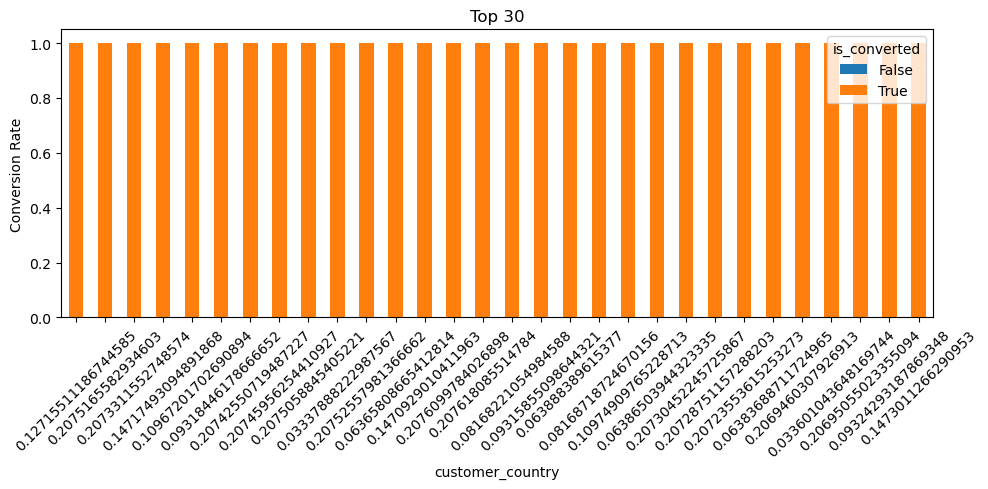

In [29]:
plot_top_conversion_rates(df_train, 'customer_country', 'is_converted', top_n=30)

# 2. business_unit

# 3. com_reg_ver_win_rate
- (Vertical Level 1, business unit, region을 기준으로 oppty 비율을 계산)

In [30]:
print(df_train['com_reg_ver_win_rate'].isnull().sum())
print(df_test['com_reg_ver_win_rate'].isnull().sum())

44731
3483


In [31]:
df_train['com_reg_ver_win_rate'].unique()

array([0.06666667, 0.08888889, 0.04081633, 0.00393701,        nan,
       0.05753425, 0.075     , 0.04464286, 0.08433735, 0.0199005 ,
       0.07494867, 0.04347826, 0.03119584, 0.14705882, 0.03305785,
       0.08069164, 0.33333333, 0.04310345, 0.11627907, 0.01351351,
       0.04854369, 0.01818182, 0.01185771, 0.21428571, 0.3902439 ,
       0.03225806, 0.01754386, 0.03278689, 0.05555556, 0.01515152,
       0.46153846, 0.06818182, 0.08333333, 0.26923077, 0.18181818,
       0.23076923, 0.64285714, 0.16666667, 0.01724138, 0.05389222,
       0.04968944, 0.01098901, 0.06779661, 0.03703704, 0.00378788,
       0.36363636, 0.10526316, 0.61538462, 0.08695652, 0.05442177,
       0.05319149, 0.07142857, 0.04      , 0.04166667, 0.02892562,
       0.11842105, 0.04918033, 0.11864407, 0.07324841, 0.02898551,
       0.01960784, 0.02272727, 0.004     , 0.125     , 0.01694915,
       0.12412178, 0.13636364, 0.02020202, 0.11363636, 0.03603604,
       0.06956522, 0.5       , 1.        , 0.25      , 0.44444

In [32]:
# 결측치 -> 0으로 대체

In [33]:
df_train['com_reg_ver_win_rate'] = df_train['com_reg_ver_win_rate'].fillna(0)
df_test['com_reg_ver_win_rate'] = df_test['com_reg_ver_win_rate'].fillna(0)


In [34]:
print(df_train['com_reg_ver_win_rate'].isnull().sum())
print(df_test['com_reg_ver_win_rate'].isnull().sum())

0
0


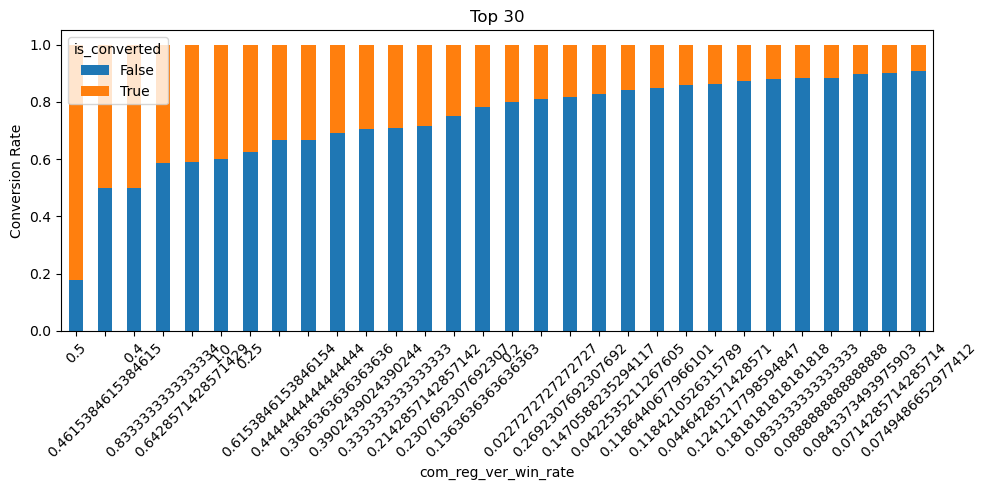

In [35]:
plot_top_conversion_rates(df_train, 'com_reg_ver_win_rate', 'is_converted', top_n=30)

# 4.customer_idx

In [36]:

df_train['customer_idx'].unique()

array([32160, 23122,  1755, ..., 19249, 40327, 30268])

In [37]:
print(df_train['customer_idx'].isnull().sum())
print(df_test['customer_idx'].isnull().sum())

0
0


In [38]:
df_train['customer_idx'].value_counts()

customer_idx
47466    7686
25096    2421
37680     367
18030     331
21321     162
         ... 
39487       1
41241       1
39422       1
22515       1
30268       1
Name: count, Length: 35112, dtype: int64

In [39]:
# train에 없는 값이 test에 있을까? 

train_vals = set(df_train['customer_idx'].unique())
test_vals = set(df_test['customer_idx'].unique())

test_not_train = test_vals - train_vals

print(test_not_train) 

{16384, 1, 4, 8200, 9, 32776, 32779, 24588, 24589, 40973, 8208, 24592, 40976, 32787, 22, 40983, 8219, 30, 36, 8231, 24619, 43, 32813, 32814, 16431, 48, 24620, 8242, 41007, 54, 24632, 8249, 16452, 69, 24644, 8266, 8271, 41043, 16467, 24661, 32857, 16477, 24672, 32866, 24675, 32868, 104, 107, 41070, 16495, 41071, 113, 16497, 24691, 8305, 24687, 32888, 32892, 130, 41094, 136, 16521, 24714, 41098, 24717, 41103, 41108, 24727, 32924, 156, 163, 32931, 166, 167, 41137, 16562, 8372, 24758, 183, 41143, 32952, 8379, 41155, 32964, 16580, 32965, 32968, 32969, 24777, 16587, 204, 203, 205, 41166, 24778, 8401, 24780, 8406, 214, 24795, 41180, 8414, 16609, 16610, 8418, 32996, 8417, 33003, 24814, 16623, 16627, 41214, 24831, 256, 16641, 16645, 33033, 16651, 24844, 33037, 24846, 24848, 41235, 8474, 8475, 33050, 33052, 24862, 8479, 8480, 41247, 16681, 16683, 33072, 41265, 33078, 41273, 41274, 315, 24895, 16705, 8514, 33093, 24902, 24903, 24904, 41289, 8522, 24909, 33102, 8526, 33105, 33106, 33107, 33108, 24

In [40]:
train_vals = set(df_train['customer_idx'].unique())
test_vals = set(df_test['customer_idx'].unique())

test_not_train = test_vals - train_vals

# df_test['customer_idx'] 열에서 test_not_train에 해당하는 값이 있는지 확인합니다.
mask = df_test['customer_idx'].isin(test_not_train)

# df_test['customer_idx'] 값이 test_not_train에 해당하는 경우에만 0으로 대체합니다.
df_test.loc[mask, 'customer_idx'] = 0

# 업데이트된 값의 개수를 출력합니다.
print(df_test['customer_idx'].value_counts())


customer_idx
0        4073
47466     363
9324      120
23341      31
37680      14
         ... 
13574       1
35229       1
18392       1
27319       1
40292       1
Name: count, Length: 446, dtype: int64


In [41]:
train_vals = set(df_train['customer_idx'].unique())
test_vals = set(df_test['customer_idx'].unique())

test_not_train = test_vals - train_vals

print(test_not_train)

{0}


In [42]:

top_values = df_train['customer_idx'].value_counts().tail(500)
print(top_values)


customer_idx
46688    1
43427    1
23508    1
3812     1
36774    1
        ..
39487    1
41241    1
39422    1
22515    1
30268    1
Name: count, Length: 500, dtype: int64


In [43]:
print((df_train['customer_idx'] == 0).any())


False


In [44]:
count_1 = (df_train['customer_idx'].value_counts() == 1).sum()
print(f"빈도수가 1인 행의 개수: {count_1}")


빈도수가 1인 행의 개수: 27331


In [45]:
counts = df_train['customer_idx'].value_counts()
threshold = 5
low_frequency = counts[counts < threshold].index
df_train['customer_idx'] = df_train['customer_idx'].replace(low_frequency, 0)


In [46]:
counts = df_test['customer_idx'].value_counts()
threshold = 5
low_frequency = counts[counts < threshold].index
df_test['customer_idx'] = df_test['customer_idx'].replace(low_frequency, 0)



In [47]:
df_train['customer_idx'].value_counts()

customer_idx
0        43599
47466     7686
25096     2421
37680      367
18030      331
         ...  
7741         5
46552        5
19854        5
37990        5
29127        5
Name: count, Length: 466, dtype: int64

In [48]:
df_test['customer_idx'].value_counts()

customer_idx
0        4612
47466     363
9324      120
23341      31
37680      14
11685      13
21321      11
869        10
22433       9
4936        9
21156       9
25940       7
32240       7
27090       7
555         6
27737       6
25309       6
41880       6
5961        5
4275        5
11579       5
40491       5
19804       5
Name: count, dtype: int64

In [49]:
train_vals = set(df_train['customer_idx'].unique())
test_vals = set(df_test['customer_idx'].unique())

test_not_train = test_vals - train_vals

print(test_not_train) 

{22433, 21156, 11685, 869, 5961, 555, 23341, 27090, 25940, 41880, 11579}


In [50]:
import pandas as pd

# 가정: df_test가 DataFrame이라고 가정합니다.
train_vals = set(df_train['customer_idx'].unique())
test_vals = set(df_test['customer_idx'].unique())

test_not_train = test_vals - train_vals

# df_test['customer_idx'] 열에서 test_not_train에 해당하는 값이 있는지 확인합니다.
mask = df_test['customer_idx'].isin(test_not_train)

# df_test['customer_idx'] 값이 test_not_train에 해당하는 경우에만 0으로 대체합니다.
df_test.loc[mask, 'customer_idx'] = 0

# 업데이트된 값의 개수를 출력합니다.
print(df_test['customer_idx'].value_counts())


customer_idx
0        4720
47466     363
9324      120
37680      14
21321      11
4936        9
32240       7
27737       6
25309       6
4275        5
40491       5
19804       5
Name: count, dtype: int64


In [53]:
# 'customer_idx' 열의 데이터 타입 확인
print(df_train['customer_idx'].dtype)

# 'customer_idx' 열을 범주형으로 변환 (만약 int64일 경우)!!!!?
df_train['customer_idx'] = df_train['customer_idx'].astype(str)
df_test['customer_idx'] = df_test['customer_idx'].astype(str)

from category_encoders import CatBoostEncoder

# CatBoost 인코딩
catboost_encoder = CatBoostEncoder()

df_train['customer_idx'] = catboost_encoder.fit_transform(df_train['customer_idx'], df_train['is_converted'])
df_test['customer_idx'] = catboost_encoder.transform(df_test['customer_idx'])


object


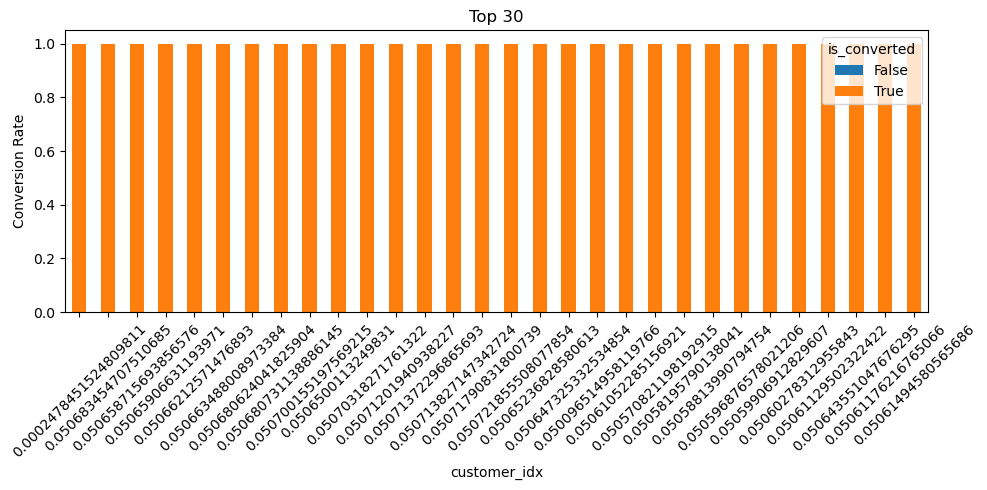

In [54]:
plot_top_conversion_rates(df_train, 'customer_idx', 'is_converted', top_n=30)

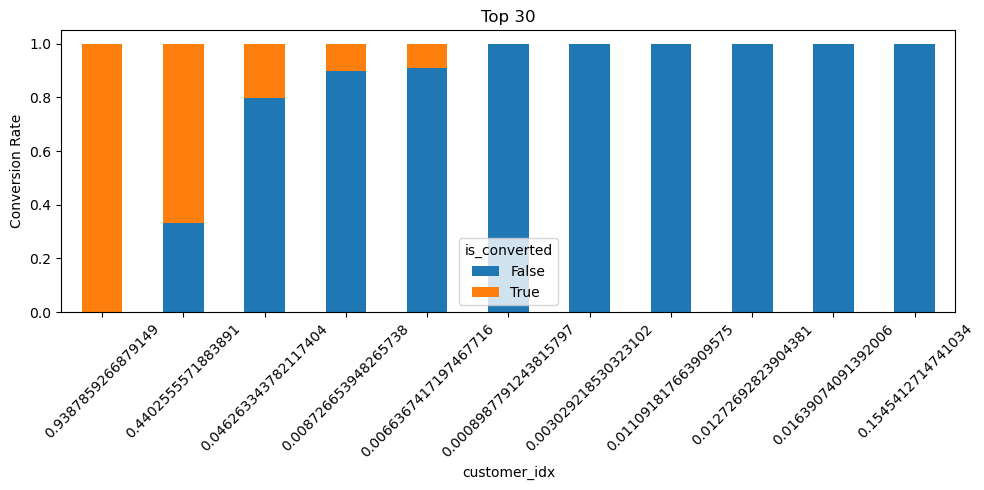

In [55]:
plot_top_conversion_rates(df_test, 'customer_idx', 'is_converted', top_n=30)

# 5.customer_type

In [56]:
df_train['customer_type'].value_counts()

customer_type
End-Customer                    6647
End Customer                    3996
Specifier/ Influencer           2525
Channel Partner                 1368
Service Partner                  349
Solution Eco-Partner             146
Installer/Contractor              52
Specifier / Influencer            43
Corporate                         31
HVAC Engineer                     23
Engineer                          20
Developer                         17
Technician                        16
Consultant                        15
Other                             10
Home Owner                        10
End-user                           8
Manager / Director                 8
Software/Solution Provider         7
Etc.                               6
Architect/Consultant               5
Homeowner                          5
Reseller                           5
Installer                          5
Interior Designer                  5
Distributor                        4
Others                  

In [57]:
# 소문자로 통일
df_train['customer_type'] = df_train['customer_type'].str.lower()

# 유사한 값 통합
df_train['customer_type'].replace({'end customer': 'end-customer',
                                   'specifier / influencer': 'specifier/influencer',
                                   'homeowner': 'home owner',
                                   'software / solution provider': 'software/solution provider',
                                   'manager / director': 'manager/director'}, inplace=True)




# 소문자로 통일
df_test['customer_type'] = df_test['customer_type'].str.lower()

# 유사한 값 통합
df_test['customer_type'].replace({'end customer': 'end-customer',
                                  'specifier / influencer': 'specifier/influencer',
                                  'homeowner': 'home owner',
                                  'software / solution provider': 'software/solution provider',
                                  'manager / director': 'manager/director'}, inplace=True)


In [58]:
df_train['customer_type'].value_counts()

customer_type
end-customer                  10643
specifier/ influencer          2525
channel partner                1368
service partner                 349
solution eco-partner            146
installer/contractor             52
specifier/influencer             43
corporate                        31
hvac engineer                    23
engineer                         20
developer                        17
technician                       16
consultant                       15
home owner                       15
other                            10
software/solution provider        8
manager/director                  8
end-user                          8
etc.                              6
installer                         5
interior designer                 5
reseller                          5
architect/consultant              5
distributor                       4
others                            4
system integrator                 2
dealer/distributor                2
technical assi

In [59]:
counts = df_train['customer_type'].value_counts()
threshold = 10
low_frequency = counts[counts < threshold].index
df_train['customer_type'] = df_train['customer_type'].replace(low_frequency, 'other')


In [60]:
counts = df_test['customer_type'].value_counts()
threshold = 10
low_frequency = counts[counts < threshold].index
df_test['customer_type'] = df_test['customer_type'].replace(low_frequency, 'other')

In [61]:
df_test['customer_type'].value_counts()

customer_type
end-customer             2454
specifier/ influencer     788
channel partner           327
solution eco-partner      146
service partner            98
other                       1
Name: count, dtype: int64

In [62]:
# train에 없는 값이 test에 있을까? 

train_vals = set(df_train['customer_type'].unique())
test_vals = set(df_test['customer_type'].unique())

test_not_train = test_vals - train_vals

print(test_not_train) 

set()


In [63]:
from category_encoders import CatBoostEncoder

# CatBoost 인코딩
catboost_encoder = CatBoostEncoder()

df_train['customer_type'] = catboost_encoder.fit_transform(df_train['customer_type'], df_train['is_converted'])
df_test['customer_type'] = catboost_encoder.transform(df_test['customer_type'])



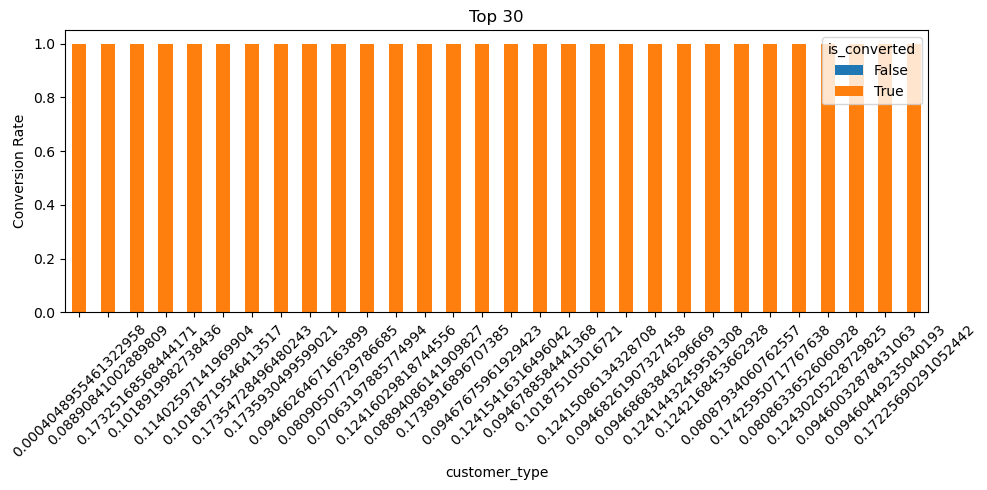

In [64]:
plot_top_conversion_rates(df_train, 'customer_type', 'is_converted', top_n=30)

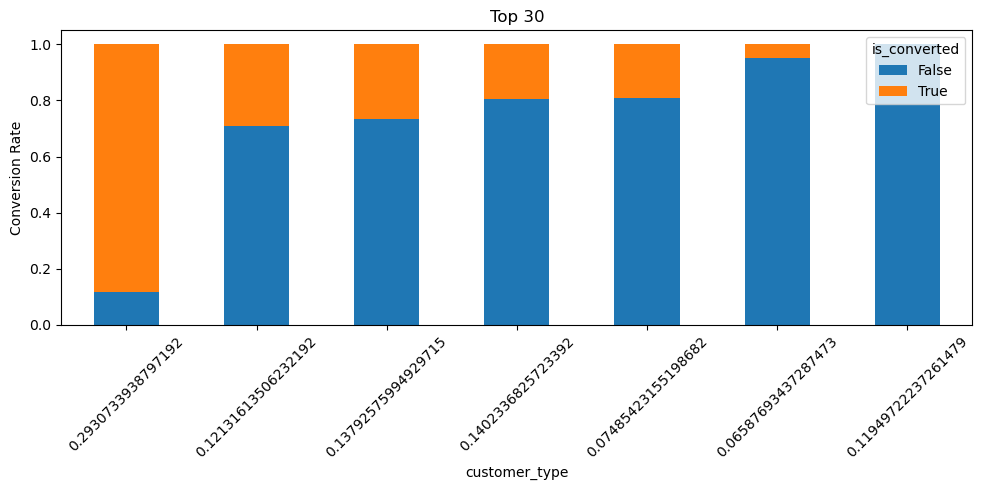

In [65]:
plot_top_conversion_rates(df_test, 'customer_type', 'is_converted', top_n=30)

# 6.historical_existing_cnt
- 이전에 Converted(영업 전환) 되었던 횟수

In [66]:
df_train['historical_existing_cnt'].value_counts()

historical_existing_cnt
4.0       2957
0.0       1973
1.0       1967
19.0      1441
16.0      1132
          ... 
404.0        1
145.0        1
1394.0       1
199.0        1
108.0        1
Name: count, Length: 136, dtype: int64

In [67]:
df_train['historical_existing_cnt'].isnull().sum()

45543

In [68]:
df_train['historical_existing_cnt'].describe()

count    13756.000000
mean        19.912184
std         44.697938
min          0.000000
25%          1.000000
50%          4.000000
75%         19.000000
max       1394.000000
Name: historical_existing_cnt, dtype: float64

In [69]:
#중앙값으로 결측치 채우기 (중간값이 평균보다 적절.. )
print(df_train['historical_existing_cnt'].mean(),df_train['historical_existing_cnt'].median())
print(df_test['historical_existing_cnt'].mean(),df_test['historical_existing_cnt'].median())

19.91218377435301 4.0
21.27294117647059 4.0


In [70]:
df_train['historical_existing_cnt'].fillna(df_train['historical_existing_cnt'].median(), inplace=True)
df_test['historical_existing_cnt'].fillna(df_test['historical_existing_cnt'].median(), inplace=True)

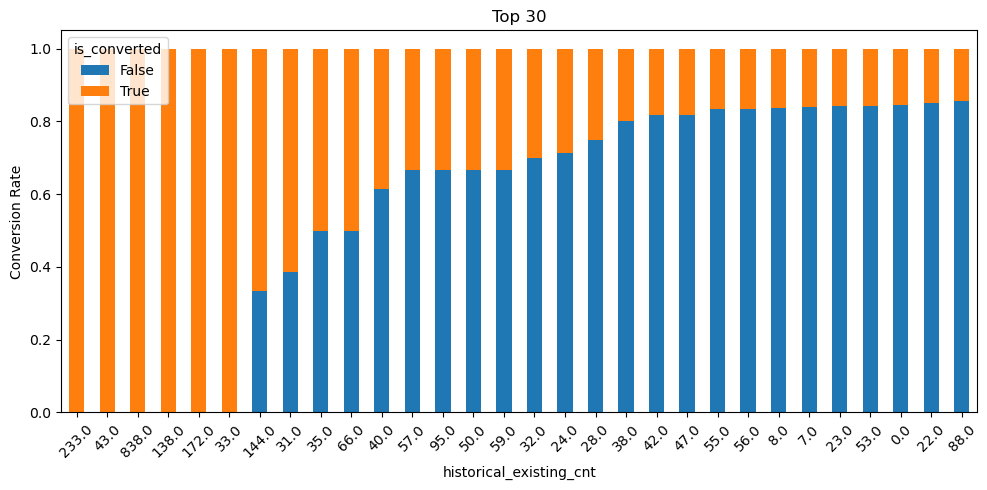

In [71]:
plot_top_conversion_rates(df_train, 'historical_existing_cnt', 'is_converted', top_n=30)

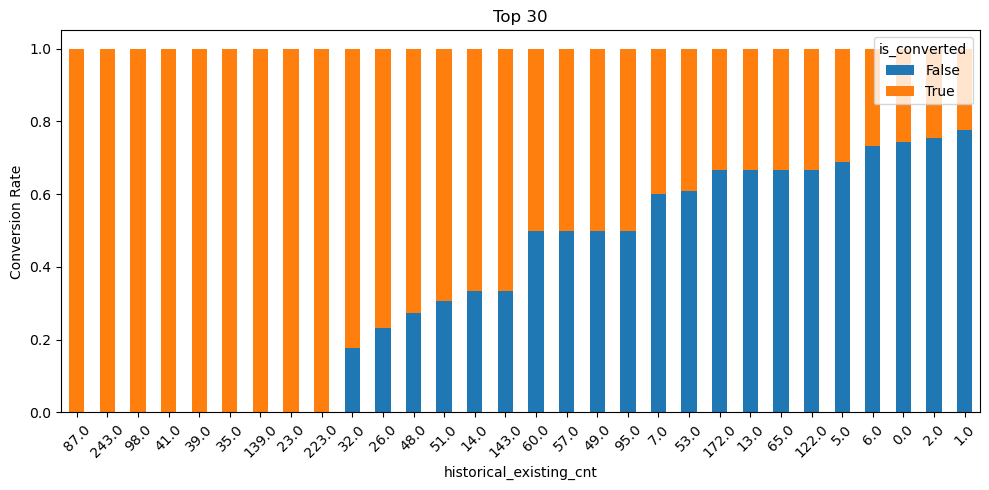

In [72]:
plot_top_conversion_rates(df_test, 'historical_existing_cnt', 'is_converted', top_n=30)

# 6. id_strategic_ver,it_strategic_ver,idit_strategic_ver
- id_strategic_ver : (도메인 지식) 특정 사업부(Business Unit이 ID일 때), 특정 사업 영역(Vertical Level1)에 대해 가중치를 부여
- it_strategic_ver :	(도메인 지식) 특정 사업부(Business Unit이 IT일 때), 특정 사업 영역(Vertical Level1)에 대해 가중치를 부여
- idit_strategic_ver : Id_strategic_ver이나 it_strategic_ver 값 중 하나라도 1의 값을 가지면 1 값으로 표현

# 결측치가 특정 사업부를 의미한다면??? 
ex) [business_unit'] == 'ID']['business_area'] 값이 있는 확인 결측치 대체

In [73]:
df_train['id_strategic_ver'].isnull().sum()

55855

In [74]:

# 'business_unit'이 'ID'인 경우에 해당하는 'business_area' 값 출력
df_train[df_train['business_unit'] == 'ID']['business_area'].value_counts()




business_area
corporate / office                2460
retail                            2028
education                         1356
special purpose                   1075
hotel & accommodation              984
factory                            540
government department              421
residential (home)                 385
public facility                    271
transportation                     216
hospital & health care             148
power plant / renewable energy      43
Name: count, dtype: int64

In [75]:
df_train['id_strategic_ver'].value_counts()

id_strategic_ver
1.0    3444
Name: count, dtype: int64

In [76]:
# id_strategic_ver 열에서 NaN 값이 아닌 행들만 선택
id_s_data = df_train.dropna(subset=['id_strategic_ver'])

#business_unit과 business_area로 그룹을 지어 id_strategic_ver의 평균을 계산
id_s_data_x = id_s_data.groupby(['business_unit', 'business_area'])['id_strategic_ver'].mean()
id_s_data_x

business_unit  business_area        
ID             corporate / office       1.0
               hotel & accommodation    1.0
Name: id_strategic_ver, dtype: float64

### !!! 특정 사업부(Business Unit이 ID일 때) 는 즉 corporate / office  hotel & accommodation 일때를 의미한다.

In [77]:
def fill_strategic_ver(df):
    # 조건 설정
    condition = (
        (df['id_strategic_ver'].isna()) & 
        (df['business_unit'] == 'ID') & 
        ((df['business_area'] == 'corporate / office') | (df['business_area'] == 'hotel & accommodation'))
    )

    # 조건 해당하면 결측치를 1로 대체, 나머지는 0
    df.loc[condition, 'id_strategic_ver'] = df.loc[condition, 'id_strategic_ver'].fillna(1)
    df['id_strategic_ver'].fillna(0, inplace=True)


fill_strategic_ver(df_train)
fill_strategic_ver(df_test)


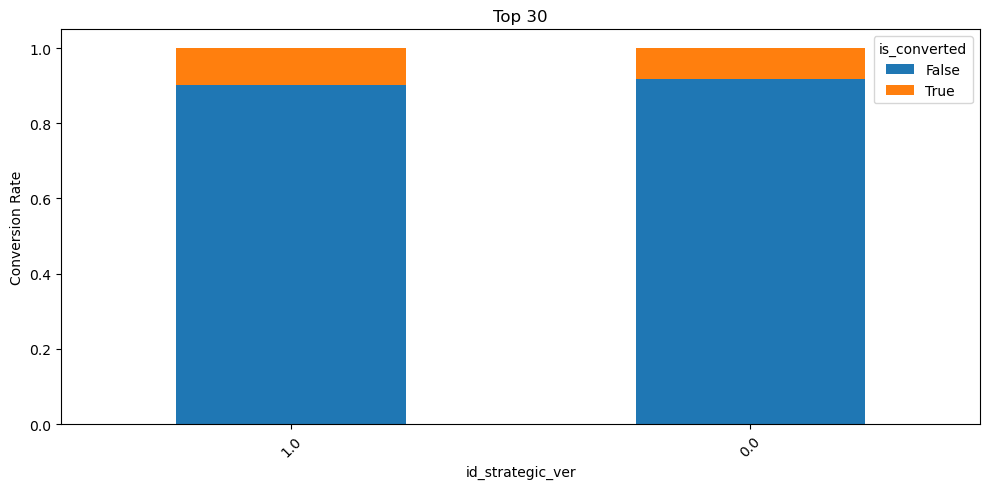

In [78]:
plot_top_conversion_rates(df_train, 'id_strategic_ver', 'is_converted', top_n=30)

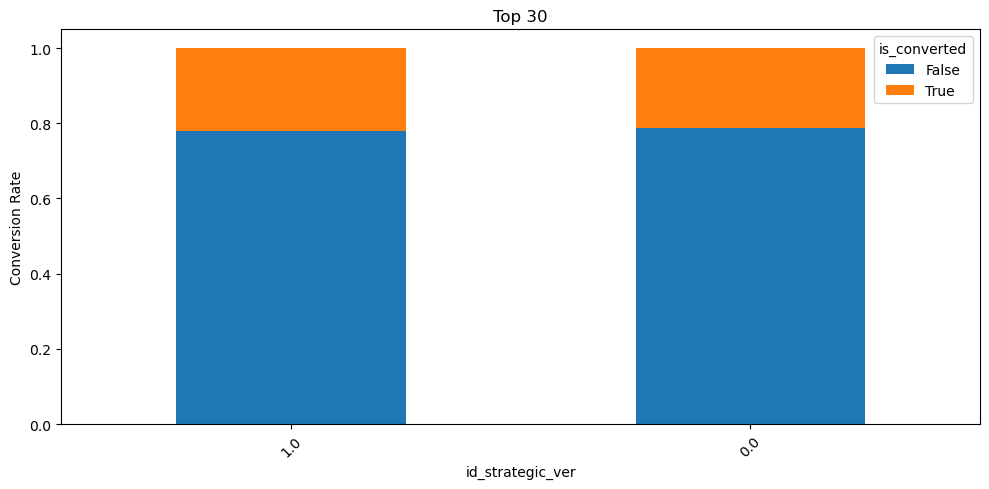

In [79]:
plot_top_conversion_rates(df_test, 'id_strategic_ver', 'is_converted', top_n=30)

# 7. it_strategic_ver

In [80]:
df_train['it_strategic_ver'].isnull().sum()

58178

In [81]:
# 'business_unit'이 'ID'인 경우에 해당하는 'business_area' 값 출력
df_train[df_train['business_unit'] == 'IT']['business_area'].value_counts()

business_area
hospital & health care            895
hotel & accommodation             791
corporate / office                330
retail                            163
education                         150
special purpose                   108
factory                            83
government department              49
residential (home)                 42
public facility                    40
transportation                     33
power plant / renewable energy      8
Name: count, dtype: int64

In [82]:
df_train['it_strategic_ver'].value_counts()

it_strategic_ver
1.0    1121
Name: count, dtype: int64

In [83]:
it_s_data = df_train.dropna(subset=['it_strategic_ver'])

it_s_data_x = it_s_data.groupby(['business_unit', 'business_area'])['it_strategic_ver'].mean()
it_s_data_x

business_unit  business_area        
IT             corporate / office       1.0
               hotel & accommodation    1.0
Name: it_strategic_ver, dtype: float64

In [84]:
def fill_strategic_ver(df):
    # 조건 설정
    condition = (
        (df['it_strategic_ver'].isna()) & 
        (df['business_unit'] == 'IT') & 
        ((df['business_area'] == 'corporate / office') | (df['business_area'] == 'hotel & accommodation'))
    )

    # 조건 해당하면 결측치를 1로 대체, 나머지는 0
    df.loc[condition, 'it_strategic_ver'] = df.loc[condition, 'it_strategic_ver'].fillna(1)
    df['it_strategic_ver'].fillna(0, inplace=True)

fill_strategic_ver(df_train)
fill_strategic_ver(df_test)


In [85]:
df_train['it_strategic_ver'].value_counts()

it_strategic_ver
0.0    58178
1.0     1121
Name: count, dtype: int64

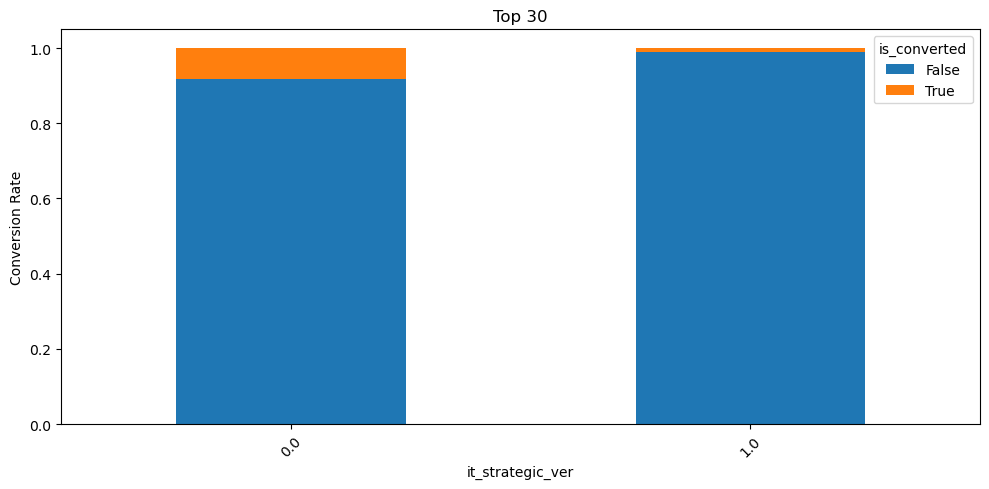

In [86]:
plot_top_conversion_rates(df_train, 'it_strategic_ver', 'is_converted', top_n=30)

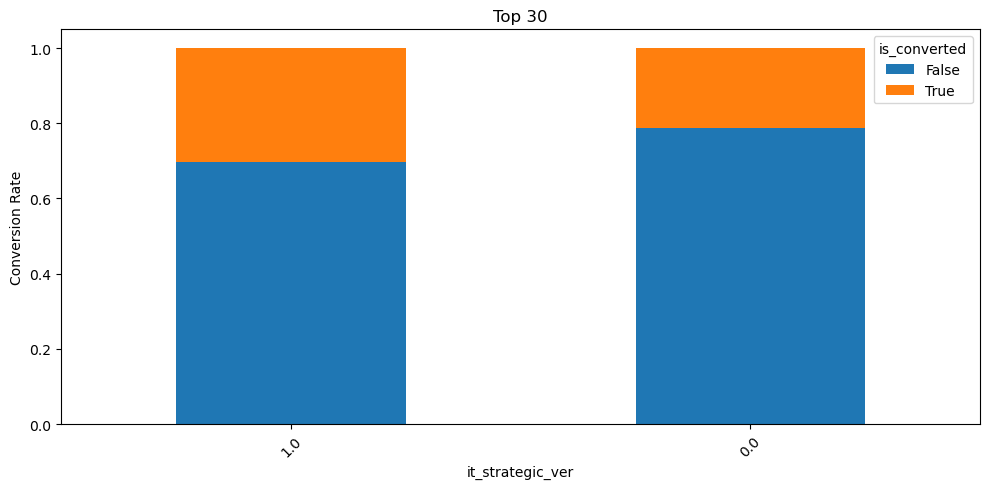

In [87]:
plot_top_conversion_rates(df_test, 'it_strategic_ver', 'is_converted', top_n=30)

# 8. idit_strategic_ver
- Id_strategic_ver이나 it_strategic_ver 값 중 하나라도 1의 값을 가지면 1 값으로 표현

In [88]:
# id, it 둘중 하나라도 있으면 1 아니면 0으로 idit를 수정
df_train['idit_strategic_ver'] = np.where((df_train['id_strategic_ver'] == 1) | (df_train['it_strategic_ver'] == 1), 1, 0)

df_test['idit_strategic_ver'] = np.where((df_test['id_strategic_ver'] == 1) | (df_test['it_strategic_ver'] ==1), 1, 0)

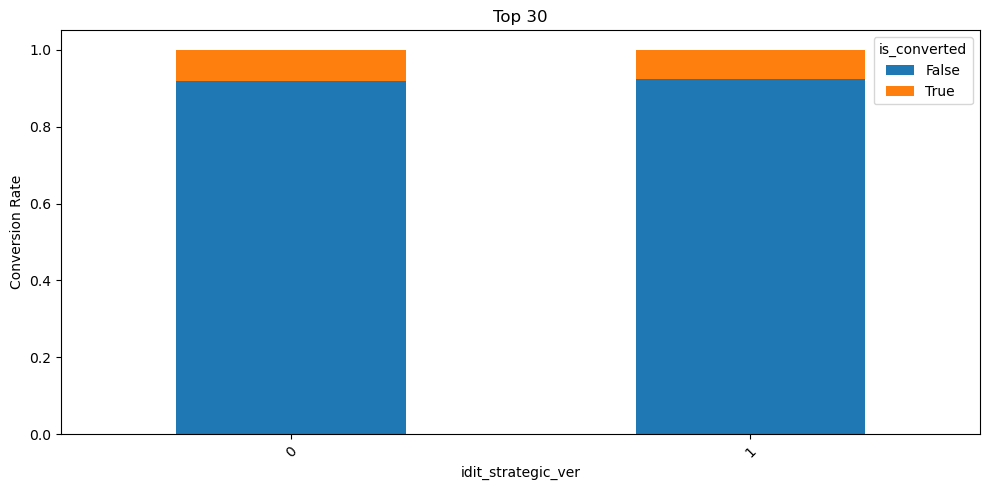

In [89]:
plot_top_conversion_rates(df_train, 'idit_strategic_ver', 'is_converted', top_n=30)

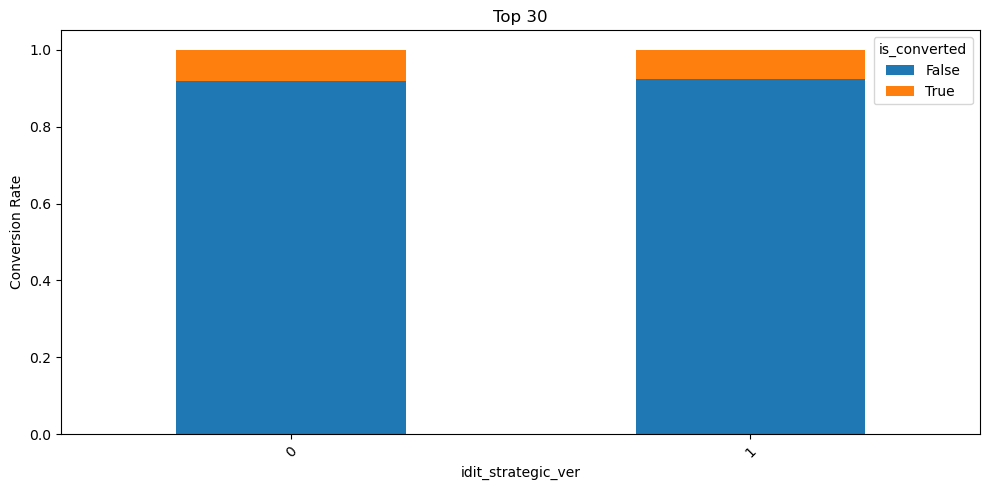

In [90]:
plot_top_conversion_rates(df_train, 'idit_strategic_ver', 'is_converted', top_n=30)

# 9. customer_job,

In [91]:
df_train['customer_job'] = df_train['customer_job'].fillna('None')

replace_job = {
   'salesman' : 'sales',
   'sales executive' : 'sales',
   'sale' : 'sales',
   'part of video wall' : 'video wall',
   'information_technology' : 'information technology',
   'designer, creative technologist' : 'technology designer',
   'no respoxse on phone will try again' : 'None',
   'no requirment' : 'None'
}

df_train['customer_job'] = df_train['customer_job'].replace(replace_job)

df_train.loc[df_train['customer_job'].str.contains('other'), 'customer_job'] ='other'
df_train.loc[df_train['customer_job'].str.contains('not'), 'customer_job'] ='None'
df_train.loc[df_train['customer_job'].str.contains('health'), 'customer_job'] = 'healthcare services'
df_train.loc[df_train['customer_job'].str.contains('administrative'), 'customer_job'] = 'administrative'
df_train.loc[df_train['customer_job'].str.contains('edu'), 'customer_job'] = 'education'
df_train.loc[df_train['customer_job'].str.contains('information technology'), 'customer_job'] = 'information technology'
df_train.loc[df_train['customer_job'].str.contains('media'), 'customer_job'] = 'media and communication'
df_train.loc[df_train['customer_job'].str.contains('research'), 'customer_job'] = 'research'
df_train.loc[df_train['customer_job'].str.contains('marketing'), 'customer_job'] = 'marketing'
df_train.loc[df_train['customer_job'].str.contains('project manager'), 'customer_job'] = 'project manager'
df_train.loc[(df_train['customer_job'].str.contains('art'))
             & df_train['customer_job'].str.contains('design'), 'customer_job'] = 'arts and design'
df_train.loc[((df_train['customer_job'].str.contains('install'))
              &df_train['customer_job'].str.contains('design')), 'customer_job'] = 'design and install'
df_train.loc[df_train['customer_job'].str.contains('sales rep'), 'customer_job']='sales'
df_train.loc[(df_train['customer_job'].str.contains('cons'))
             & ~(df_train['customer_job'].str.contains(r'purchas|design|tech|manag')), 'customer_job'] ='consulting'
df_train.loc[(df_train['customer_job'].str.contains('direct'))
             & ~(df_train['customer_job'].str.contains(r'of|purchas|design|tech|manag|pro')), 'customer_job'] = 'director'
df_train.loc[((df_train['customer_job'].str.contains('engineer'))
              &~(df_train['customer_job'].str.contains(r'design|tech|sales'))), 'customer_job'] = 'engineering'
df_train.loc[((df_train['customer_job'].str.contains('engineer'))
              &(df_train['customer_job'].str.contains('design'))), 'customer_job'] = 'design engineer'
df_train.loc[((df_train['customer_job'].str.contains('engineer'))
              &(df_train['customer_job'].str.contains('tech'))), 'customer_job'] = 'engineering & technical'
df_train.loc[(df_train['customer_job'].str.contains('tech'))
             & ~(df_train['customer_job'].str.contains(r'engineer|design|consultant|recommend|infor|sales')), 'customer_job'] = 'technical'
df_train.loc[(df_train['customer_job'].str.contains(r'direct|chairman|decision'))
             &~(df_train['customer_job'].str.contains(r'purcha|design')), 'customer_job'] = 'decision'
df_train.loc[(df_train['customer_job'].str.contains(r'ceo|executive|chief|founder'))
             & ~(df_train['customer_job'].str.contains(r'sales')), 'customer_job'] ='ceo'
df_train.loc[(df_train['customer_job'].str.contains('design'))
             &~(df_train['customer_job'].str.contains(r'art|engineer|install|tech')), 'customer_job'] = 'designer'
df_train.loc[(df_train['customer_job'].str.contains('design'))
             &~(df_train['customer_job'].str.contains(r'art|engineer|install|tech')), 'customer_job'] = 'designer'
df_train.loc[(df_train['customer_job'].str.contains('art'))
             & ~(df_train['customer_job'].str.contains(r'install|manag|owner|part')), 'customer_job'] = 'arts and design'
df_train.loc[df_train['customer_job'].str.contains('lead'), 'customer_job'] = 'decision'
df_train.loc[(df_train['customer_job'].str.contains('video')), 'customer_job'] = 'video wall'
df_train.loc[(df_train['customer_job'].str.contains('install'))
             & ~(df_train['customer_job'].str.contains('design')), 'customer_job'] = 'installer'

In [92]:
df_test['customer_job'] = df_test['customer_job'].fillna('None')

replace_job = {
   'salesman' : 'sales',
   'sales executive' : 'sales',
   'sale' : 'sales',
   'part of video wall' : 'video wall',
   'information_technology' : 'information technology',
   'designer, creative technologist' : 'technology designer',
   'no respoxse on phone will try again' : 'None',
   'no requirment' : 'None'
}

df_test['customer_job'] = df_test['customer_job'].replace(replace_job)

df_test.loc[df_test['customer_job'].str.contains('other'), 'customer_job'] ='other'
df_test.loc[df_test['customer_job'].str.contains('not'), 'customer_job'] ='None'
df_test.loc[df_test['customer_job'].str.contains('health'), 'customer_job'] = 'healthcare services'
df_test.loc[df_test['customer_job'].str.contains('administrative'), 'customer_job'] = 'administrative'
df_test.loc[df_test['customer_job'].str.contains('edu'), 'customer_job'] = 'education'
df_test.loc[df_test['customer_job'].str.contains('information technology'), 'customer_job'] = 'information technology'
df_test.loc[df_test['customer_job'].str.contains('media'), 'customer_job'] = 'media and communication'
df_test.loc[df_test['customer_job'].str.contains('research'), 'customer_job'] = 'research'
df_test.loc[df_test['customer_job'].str.contains('marketing'), 'customer_job'] = 'marketing'
df_test.loc[df_test['customer_job'].str.contains('project manager'), 'customer_job'] = 'project manager'
df_test.loc[(df_test['customer_job'].str.contains('art'))
             & df_test['customer_job'].str.contains('design'), 'customer_job'] = 'arts and design'
df_test.loc[((df_test['customer_job'].str.contains('install'))
              &df_test['customer_job'].str.contains('design')), 'customer_job'] = 'design and install'
df_test.loc[df_test['customer_job'].str.contains('sales rep'), 'customer_job']='sales'
df_test.loc[(df_test['customer_job'].str.contains('cons'))
             & ~(df_test['customer_job'].str.contains(r'purchas|design|tech|manag')), 'customer_job'] ='consulting'
df_test.loc[(df_test['customer_job'].str.contains('direct'))
             & ~(df_test['customer_job'].str.contains(r'of|purchas|design|tech|manag|pro')), 'customer_job'] = 'director'
df_test.loc[((df_test['customer_job'].str.contains('engineer'))
              &~(df_test['customer_job'].str.contains(r'design|tech|sales'))), 'customer_job'] = 'engineering'
df_test.loc[((df_test['customer_job'].str.contains('engineer'))
              &(df_test['customer_job'].str.contains('design'))), 'customer_job'] = 'design engineer'
df_test.loc[((df_test['customer_job'].str.contains('engineer'))
              &(df_test['customer_job'].str.contains('tech'))), 'customer_job'] = 'engineering & technical'
df_test.loc[(df_test['customer_job'].str.contains('tech'))
             & ~(df_test['customer_job'].str.contains(r'engineer|design|consultant|recommend|infor|sales')), 'customer_job'] = 'technical'
df_test.loc[(df_test['customer_job'].str.contains(r'direct|chairman|decision'))
             &~(df_test['customer_job'].str.contains(r'purcha|design')), 'customer_job'] = 'decision'
df_test.loc[(df_test['customer_job'].str.contains(r'ceo|executive|chief|founder'))
             & ~(df_test['customer_job'].str.contains(r'sales')), 'customer_job'] ='ceo'
df_test.loc[(df_test['customer_job'].str.contains('design'))
             &~(df_test['customer_job'].str.contains(r'art|engineer|install|tech')), 'customer_job'] = 'designer'
df_test.loc[(df_test['customer_job'].str.contains('design'))
             &~(df_test['customer_job'].str.contains(r'art|engineer|install|tech')), 'customer_job'] = 'designer'
df_test.loc[(df_test['customer_job'].str.contains('art'))
             & ~(df_test['customer_job'].str.contains(r'install|manag|owner|part')), 'customer_job'] = 'arts and design'
df_test.loc[df_test['customer_job'].str.contains('lead'), 'customer_job'] = 'decision'
df_test.loc[(df_test['customer_job'].str.contains('video')), 'customer_job'] = 'video wall'
df_test.loc[(df_test['customer_job'].str.contains('install'))
             & ~(df_test['customer_job'].str.contains('design')), 'customer_job'] = 'installer'

In [93]:
df_train['customer_job'].value_counts()

customer_job
None                              18736
engineering                        6366
other                              5618
administrative                     3362
education                          2293
                                  ...  
repair uhd 120 hz units               1
hardware                              1
quotation curator                     1
hotel manager                         1
exhibition / convention center        1
Name: count, Length: 394, dtype: int64

In [94]:
df_test['customer_job'].value_counts()

customer_job
None                                1439
engineering                          728
other                                506
education                            408
administrative                       307
information technology               231
operations                           195
purchasing                           180
consulting                           166
business development                 164
sales                                162
entrepreneurship                     119
arts and design                      104
program and project management        96
marketing                             94
media and communication               49
support                               47
healthcare services                   46
finance                               42
product management                    36
accounting                            34
real estate                           26
community and social services         22
legal                                 17
hum

In [95]:
counts = df_train['customer_job'].value_counts()
threshold = 10
low_frequency = counts[counts < threshold].index
df_train['customer_job'] = df_train['customer_job'].replace(low_frequency, 'other')

In [96]:
counts = df_test['customer_job'].value_counts()
threshold = 10
low_frequency = counts[counts < threshold].index
df_test['customer_job'] = df_test['customer_job'].replace(low_frequency, 'other')

In [97]:
train_vals = set(df_train['customer_job'].unique())
test_vals = set(df_test['customer_job'].unique())

test_not_train = test_vals - train_vals

print(test_not_train)

set()


In [98]:
from category_encoders import CatBoostEncoder

# CatBoost 인코딩
catboost_encoder = CatBoostEncoder()

df_train['customer_job'] = catboost_encoder.fit_transform(df_train['customer_job'], df_train['is_converted'])
df_test['customer_job'] = catboost_encoder.transform(df_test['customer_job'])


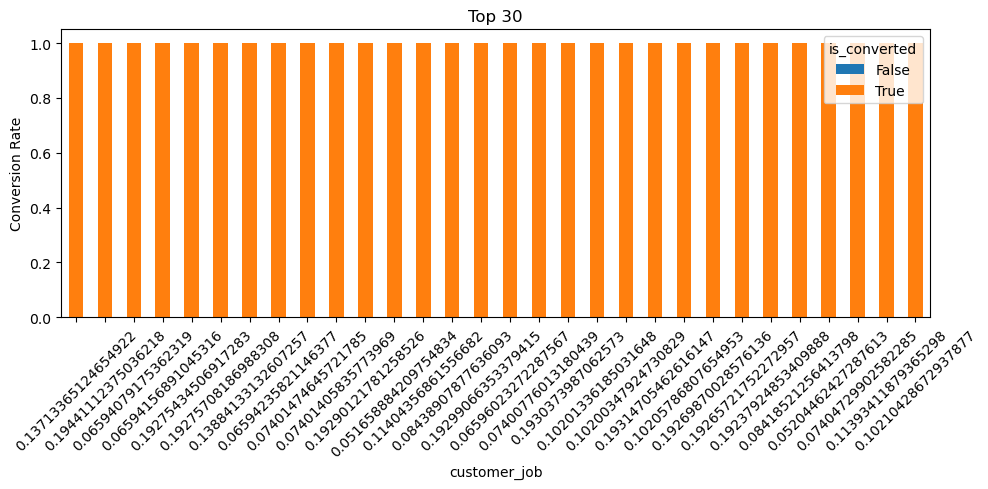

In [99]:
plot_top_conversion_rates(df_train, 'customer_job', 'is_converted', top_n=30)

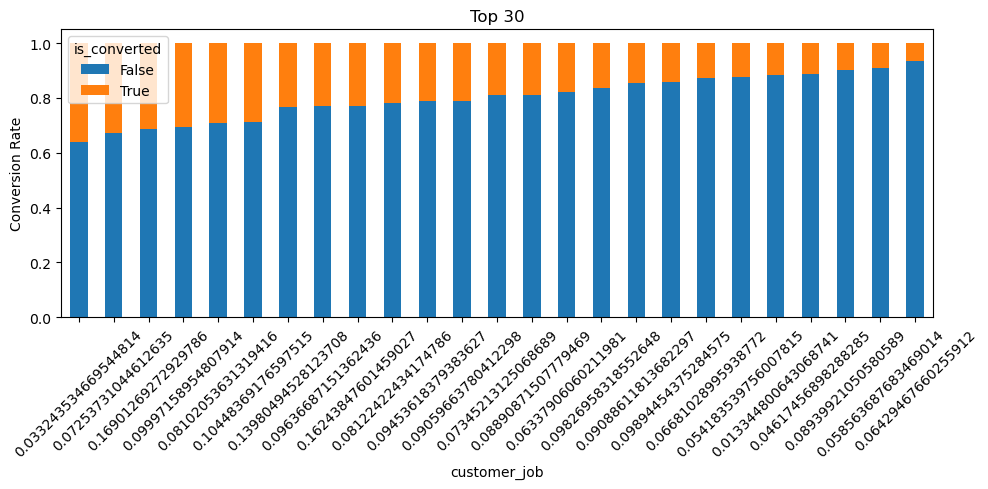

In [100]:
plot_top_conversion_rates(df_test, 'customer_job', 'is_converted', top_n=30)

# 10 . customer_position

In [101]:
df_train['customer_position'].isnull().sum()

0

In [102]:
df_test['customer_position'].isnull().sum()

0

In [103]:
# 각 단어별로 분리해 보려고 했으나 그럼 여러 직위, 직무와 중복되는 현상이 발생.
# 단어 전체를 리스트에 넣어 각각 분류 진행.

none = ['none', 'unpaid', 'not applicable', 'bulgaria', ]

other = ['other', 'others', 'no influence']

customer = ['customer', 'end user', 'commercial end user',
                 'this is a consume display requirement for home purpose ']

# ceo/founder
ceo = ['ceo', 'founder', 'cofounder', 'ceo fundador', 'co founder',
           'ceo founder', 'c level executive', 'c levelexecutive', 
           'entrepreneurship', 'vp', 'proprietário a ', 'genel müdür', 
           'the big boss', 'chief executive officer']

# 의사결정자 decision maker(이사, 의장 등도 포함)
decision = ['decision', 'decision maker', 'decision influencer', 'gerente', 
                 'business unit director', 'chairman', 
                 'principal director', 'principal   director',
                'leadership executive office owner']

# 정부 government
government = ['government', 'vicepresident', 'vice president', 'president',]

# 인턴 intern
intern = ['intern', 'entrylevel', 'entry level']

# 교사, 교수 등 educator
educator = ['educator', 'math and physics teacher', 'physics teacher', 
            'professor of mathematics', 'assistant professor', 
            'principal at oxford integrated pu science college', 
            'physics and mathematics teacher', 
            'science teacher', 'prof', 'prof ', 'science teacher', 'academic specialist',
            'education', 'maths lecturer', 
            'academic coordinator  post graduate teacher  accountancy  business studies   tgt  ict ', 
            'english trainer for ielts toefl pte gre sat exams ', 
            'director cum faculty at gaining apex coaching centre',
            'associate professor in electronics engg', 'asst prof ', 
            'neet  olympiad expert faculty', 'teacher', 'guest faculty', 
            'physics faculty', 'teacher middle school coordinator', 
            'assistant professor of enlish', 'professor', 'quantitative aptitude faculty', 
            'associate professor', 'hon dean', 'chemistry teacher', 'education professional', 
            'senior lecturer', 'pgt physics', 'pgt chemistry']

# 컨설턴트 consultant
consultant = ['consultant', 'consulting', 'architecture consult', 
             'architect consultant', 'commercial consultant']

# 의료직 hospital
hospital = ['hospital', 'tierarzt', 'főorvos', 'surgery professional', 
                 'pathologist', 'radiology professional']

# 영업직 sales
sales = ['sales', 'business development sales', 'subsidiary sales  ise ', ]

# 전시회 exhibition
exhibition = ['exhibition', 'exhibitiontv', 'mindenes', 
             'other   please specify   cedia association']

# 리서치 research
research = ['research', 'market intelligence research']

# 제조
manufacturer = ['manufacturer', 'medical device manufacturer']

# 기술직 technical
technical = ['technical', 'técnico']

lists = [none, other, customer, ceo, decision, 
         government, intern, educator, consultant, hospital,
         sales, exhibition, research, manufacturer, technical]

def set_pos(df_col):
    for j in range(0, len(lists)):
        for i in range(0, len(df_col)):
             if df_col.loc[i] in lists[j]:
                df_col.loc[i] = lists[j][0]
                
cp_set = df_train['customer_position'].str.replace(pat = '[\W_]', repl = ' ', regex = True)
set_pos(cp_set)
df_train['customer_position'] = cp_set

cp_set_test = df_test['customer_position'].str.replace(pat = '[\W_]', repl = ' ', regex = True)
set_pos(cp_set_test)
df_test['customer_position'] = cp_set_test

In [104]:
df_train['customer_position'].value_counts()

customer_position
none                           19712
ceo                             8854
manager                         8217
other                           7466
director                        4843
intern                          2665
associate analyst               2597
partner                         2536
trainee                          849
government                       550
customer                         437
hospital                         206
installer                         60
educator                          48
decision                          43
manufacturer                      34
consultant                        29
cargo                             27
software  solution provider       25
homeowner                         21
system integrator                 21
employee                          14
engineering                        9
exhibition                         7
administrative                     5
operations                         3
sales               

In [105]:
counts = df_train['customer_position'].value_counts()
threshold = 10
low_frequency = counts[counts < threshold].index
df_train['customer_position'] = df_train['customer_position'].replace(low_frequency, 'other')

In [106]:
counts = df_test['customer_position'].value_counts()
threshold = 10
low_frequency = counts[counts < threshold].index
df_test['customer_position'] = df_test['customer_position'].replace(low_frequency, 'other')

In [107]:
df_train['customer_position'].value_counts()

customer_position
none                           19712
ceo                             8854
manager                         8217
other                           7511
director                        4843
intern                          2665
associate analyst               2597
partner                         2536
trainee                          849
government                       550
customer                         437
hospital                         206
installer                         60
educator                          48
decision                          43
manufacturer                      34
consultant                        29
cargo                             27
software  solution provider       25
homeowner                         21
system integrator                 21
employee                          14
Name: count, dtype: int64

In [108]:
train_vals = set(df_train['customer_job'].unique())
test_vals = set(df_test['customer_job'].unique())

test_not_train = test_vals - train_vals

print(test_not_train)

{0.09453618379383627, 0.16901269272929786, 0.07345213125068689, 0.09826958318552648, 0.08890871507779469, 0.08122422434174786, 0.054183539756007815, 0.06681028995938772, 0.06429467660255912, 0.09059663780412298, 0.09088611813682297, 0.07253731044612635, 0.06337906060211981, 0.09636687151362436, 0.13980494528123708, 0.058563687683469014, 0.08939921050580589, 0.08102053631319416, 0.10448369176597515, 0.033243534669544814, 0.013344800643068741, 0.04617456898288285}


In [109]:
from category_encoders import CatBoostEncoder

# CatBoost 인코딩
catboost_encoder = CatBoostEncoder()

df_train['customer_position'] = catboost_encoder.fit_transform(df_train['customer_position'], df_train['is_converted'])
df_test['customer_position'] = catboost_encoder.transform(df_test['customer_position'])


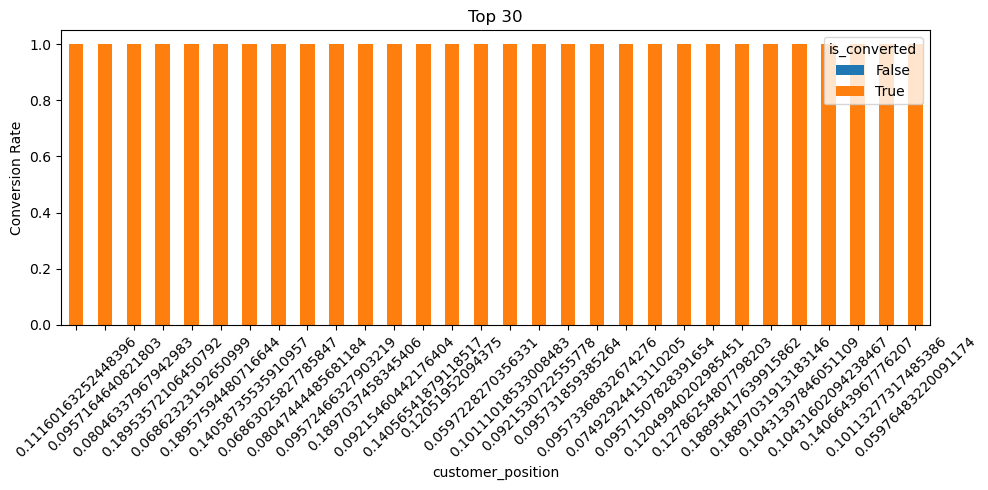

In [110]:
plot_top_conversion_rates(df_train, 'customer_position', 'is_converted', top_n=30)

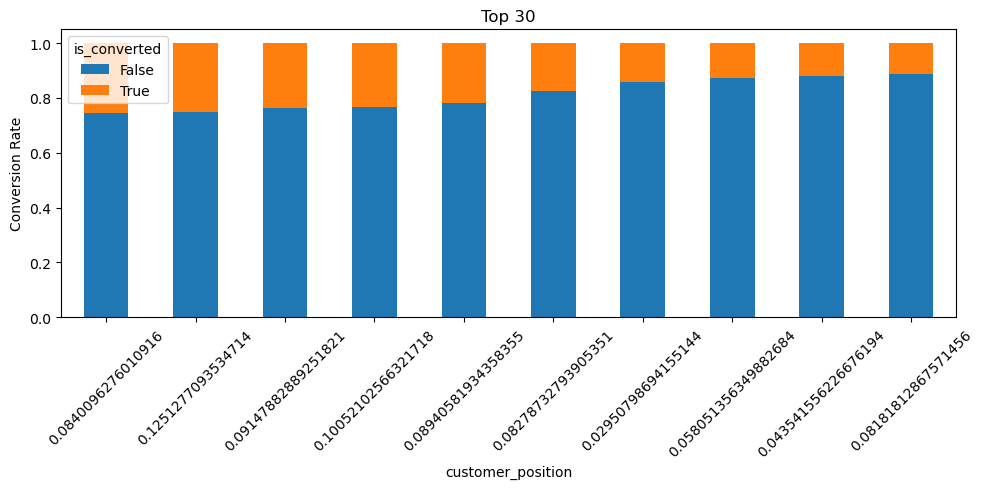

In [111]:
plot_top_conversion_rates(df_test, 'customer_position', 'is_converted', top_n=30)

# 11. product_subcategory
- product_category	요청 제품 카테고리
- product_subcategory	요청 제품 하위 카테고리
- product_modelname	요청 제품 모델명

In [112]:
df_train['product_category']

0                 multi-split
1                 multi-split
2                single-split
3                         vrf
4                 multi-split
                 ...         
59294                     vrf
59295                    etc.
59296            single-split
59297                    etc.
59298    monior/monitor tv,tv
Name: product_category, Length: 59299, dtype: object

In [113]:
df_train['product_subcategory'] = df_train['product_subcategory'].fillna('None').replace('and', ',').replace('|', ',').str.strip().str.split(',')
df_test['product_subcategory'] = df_test['product_subcategory'].fillna('None').replace('and', ',').replace('|', ',').str.strip().str.split(',')
df_train['product_modelname'] = df_train['product_modelname'].fillna('None').replace('and', ',').replace('|', ',').str.strip().str.split(',')
df_test['product_modelname'] = df_test['product_modelname'].fillna('None').replace('and', ',').replace('|', ',').str.strip().str.split(',')

sub_modelname_mapping = {
    # 모델명 보고 전처리
    '14HQ701G-BP':'Digital X-Ray Detector with a-Si TFT',
    '16Z90R-G.AP7BF':'LG gram 16 Ultra-lightweight',
    '21HQ513D':'IPS Diagnostic Monitor',
    '24MP400':'PC Monitor',
    '27QP88D':'QHD Monitor Ergo Dual',
    '28MQ780':'DualUp Monitor',
    '31HN713D':'IPS Diagnostic Monitor',
    '32UD99-W':'UHD IPS LED Monitor',
    '32UK550':'Class 4K UHD Monitor',
    '32UN880':'UHD 4K Ergo IPS Monitor',
    '32hl512D':'Diagnostic Monitor',
    '34WN780':'LED Monitor',
    '43HT3WJ':'One:Quick Flex',
    '43UH5J':'UHD Standard Signage',
    '43US660H':'US660H Series',
    '43US660H (Japan)':'US660H Series',
    '43US660H (NA)':'4K UHD Hospitality TV with Pro:Centric Direct', # 홈페이지에서 얘만 카테고리 다름.
    '43US660H (SCA)':'US660H Series',
    '43US660H (Colombia)':'US660H Series',
    '43US660H (ASIA)':'US660H Series',
    '43US660H (MEA)':'US660H Series',
    '49VL5G-M':'49" 500 nits FHD Slim Bezel Video Wall',
    '50UQ751C0SF':'4K UHD Smart TV',
    '55CT5WJ':'One:Quick Works',
    '55CT5WJ-ZJ':'One:Quick Works for Zoom Rooms',
    '43HT3WJ':'One:Quick Flex',
    'SC-00DA':'One:Quick Share',
    '55UR640':'UHD TV Signage',
    '55UR640 (INDIA)':'UHD TV Signage',
    '55UR640 (UAE)':'UHD TV Signage',
    '55UR640 (ASIA)':'UHD TV Signage',
    '55UR640 (MEA)':'UHD TV Signage',
    '55UR640 (EU/CIS)':'UHD TV Signage',
    '55UR640 (SCA)':'UHD TV Signage',
    '55UR640 (Colombia)':'UHD TV Signage',
    '55UR640 (NA)':'UHD TV Signage',
    '65EP5G OLED Pro':'UltraFine Display OLED Pro',
    '75XS4G':'Window Facing Display',
    'Ai/Machine Learning | Antennas,  Transmitters And Towers | Audience Measurement | Cameras And Lenses':['AI/Machine Learning', 'Antennas/Transmitters/Towers', 'Audience Measurement', 'Cameras/Lenses'],
    'AI/Machine Learning':'AI/Machine Learning', 
    'Antennas':'Antennas',
    'Transmitters and Towers':'Transmitters/Towers',
    'Audience Measurement':'Audience Measurement',
    'Cameras and Lenses':'Cameras/Lenses',
    'DualUp(28MQ780)':'DualUp Monitor',
    'Ergo Dual(27QP88D)':'QHD Monitor Ergo Dual',
    'GMBD035':'Mesh LED',
    'IDB':'IDB',
    'LAD033F':'LG Miraclass',
    'Lg Supersign Cms':'Lg Supersign Cms', # 한번에 컨트롤 할 수 있는 소프트웨어
    'LTAK140':'Transparent Film',
    'LTAK140-GU':'Transparent Film',
    'LTAK140-GV':'Transparent Film',
    'LTAK140-GW':'Transparent Film',
    'Only Installation Need':'Only Installation Need',
    'UltraFine Ergo(32UN880)':'UHD 4K Ergo IPS Monitor',
    'UltraWide Ergo(34WN780)':'LED Monitor',
    
    # 서브카테고리 자체 전처리
    'Pro:Centeric Tv':'Pro:Centric Tv',
    'Pro:Centrc Tv':'Pro:Centric Tv',
    'OLED 透明觸控顯示屏':'OLED transparent touch display',
    'All Monitors &Pcs': 'All Monitors & Pcs',
    '透明 LED 顯示貼':'Transparent LED display sticker',
    'SH7DD 系列':'SH7DD series',
    'จอภาพเพื่อการวินิจฉัย':'Monitor for navigation',
    'UH7F 系列':'UH7F series',
    'VL5F 系列':'VL5F series',
    'TR3BG 系列':'TR3BG series',
    'UT781H 系列':'UT781H series',
    'Indoor Versatile 系列':'Indoor Versatile series',
    'VL5D 系列':'VL5D series',
    'LT660H 系列':'LT660H series',
    'จอภาพสำหร บการตรวจสอบทางคล น ก':'Monitor for mechanical inspection',
    'จอภาพสำหรับการตรวจสอบทางคลินิก':'Monitor for mechanical inspection',
    'Curvable Oled Sigange':'Curvable Oled Signage',
    'Diagnostic Monitor':'Diagnostic Monitors',
    'Flat Oled Sigange':'Flat Oled Signage',
    'Interactive Digital Board':'IDB',
    
    'LS341H':'Ls341H series',
    'UltraWide™ Monitors':'Ultrawide Monitors',
    'Stadium Series (Perimeter)':'Stadium Series',
    'Stadium Series (Ribbon Board)':'Stadium Series',
    'UT640S':'UT640S Series',
    'UT781H':'Ut781H Series',
    'UL3J':'UHD Digital Signage',
    '65TR3DJ':'CreateBoard',
    '50US660H0SD.BWZ':'TV 50" LG 4K Hotel Quick PRO',
    '65TR3BF':'One:Quick e-Board',
    '55XS4J-B Écran Vitrine':'55" IPS Full HD Window Facing Display',
    'Monitor De Diagnostico':'Diagnostic Monitor',
    '75UH5C':'UH5C Series',
    '55VH7E-H':'VH7E-H Series',
    'moniteurs_de_chirurgicaux':'Surgical Monitors',
    '75UR640S':'UHD TV Signage',
    'UQ801':'TV', # 모델명 정확하지 않음. 대체로 Tv에 해당되는 일부 모델명.
    '49VL5J':'49" 500 nits FHD Slim Bezel Video Wall',
    
    # 조회 불가
    'Budget High For Vrf , He Will Buy The Split Ac':'Other',
    'Budget Is Higher For Vrf':'Other',
    'This Is Being Dealt With By Lg Germany.':'Other',
    'We Dont Offer T/F Spoke To Ha Pm':'Other',
    'Inquiry Forwarded To Shaker':'Other',
    'Want Split Ac':'Other',
    'Passed On To Fixxy Distribution':'Other',
    'This Is Being Dealt With By Lg Germany.':'Other',
    'ALL Surgical':'Other',
    'Inquiry forwarded to Shaker':'Other',
    'Passed on to Fixxy distribution':'Other',
    'Required After 3 Months':'Other',
    'Surgical':'Other',
    'This is being dealt with by LG Germany.':'Other',
    'Want Split AC':'Other',
    'Zero Clients':'Other',
    'Series':'Other',
    '49':'Other',
    'Hotel':'Other',
    'Mi':'Other',
    'Category':'Other',
    
    'Architect , We Are Meeting For Enqiry Generation ( This Is Not A Inquiry)':'Other',
    'Architect ,  We Are Meeting For Enqiry Generation ( This Is Not A Inquiry)':'Other',
    'Regarding Dealership':'Other',
    'Budget Is Higher For Vrf':'Other',
    'Budget High For Vrf ,  He Will Buy The Split Ac':'Other',
    'We Dont Offer T/F Spoke To Ha Pm':'Other',
    
    # 기타
    'Etc.':'Other',
    'Etc ':'Other',
    'etc ':'Other',
    'Etc':'Other',
    'etc':'Other',
    'Other':'Other',
    'Others':'Other',
    '其他':'Other',
}       

def sub_mapping(df):
    for i in range(0, len(df['product_modelname'])): # 행 개수
        new_list = []
        
        for j in range(0, len(df['product_modelname'][i])): # 모델명 개수
            for k in range(0, len(df['product_subcategory'][i])): # 서브카테고리 개수
                modelname = df['product_modelname'][i][j] # 모델명 하나씩 대체
                subcategory = df['product_subcategory'][i][k] # 서브카테고리 이상값 대체
                
                if 'None' not in df['product_subcategory'][i]:
                    # 서브카테고리 None 아니고, mapping 대상 있으면 mapping
                    if subcategory in sub_modelname_mapping.keys(): 
                        new_list.append(sub_modelname_mapping[subcategory])
                    
                    # 서브카테고리 None 아니고, mapping 대상 없으면 값 그대로 넣기
                    else:
                        new_list.append(df['product_subcategory'][i][k]) 
                    
                # 서브카테고리 None, mapping 대상 있으면 mapping
                elif modelname in sub_modelname_mapping.keys():
                    new_list.append(sub_modelname_mapping[modelname])

                # 서브카테고리 None, mapping 대상 없으면 모델명으로 값 대체
                else:
                    new_list.append(modelname)
                    
        # 문자열로 결측치 대체  
        df['product_subcategory'][i] = ', '.join(new_list)
        df['product_modelname'][i] = ', '.join(df['product_modelname'][i])

sub_mapping(df_train)
sub_mapping(df_test)


# 2차로 맵핑. 문장 대소문자 때문에 오류 많아서 아예 대체.
re_mapping = [
    'Architect*,**We*are*Meeting*for*Enqiry*Generation*(*This*is*not*a*Inquiry)',
    'AI/Machine*Learning*|*Antennas,**Transmitters*and*Towers*|*Audience*Measurement*|*Cameras*and*Lenses',
    'Budget*is*Higher*for*VRF',
    'Budget*high*for*VRF*,**He*will*buy*the*split*ac',
    'We*dont*offer*T/F*spoke*to*HA*PM',
]

def re_map(df):
    sp = df['product_subcategory']
    for i in range(0, len(sp)):
        j = sp[i].replace(' ', '*')
        if j in re_mapping:
            df.loc[i, 'product_subcategory'] = 'Other'
    
    # 대소문자 일치시켜서 그룹화
    df['product_subcategory'] = df['product_subcategory'].str.title()
    
re_map(df_train)
re_map(df_test)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [114]:
counts = df_train['product_subcategory'].value_counts()
threshold = 10
low_frequency = counts[counts < threshold].index
df_train['product_subcategory'] = df_train['product_subcategory'].replace(low_frequency, 'Other')

In [115]:
counts = df_test['product_subcategory'].value_counts()
threshold = 10
low_frequency = counts[counts < threshold].index
df_test['product_subcategory'] = df_test['product_subcategory'].replace(low_frequency, 'Other')

In [116]:
df_train['product_subcategory'].value_counts()

product_subcategory
None                                         48489
Dualup Monitor                                 617
Other                                          575
Uhd 4K Ergo Ips Monitor                        574
All Medical Displays                           446
                                             ...  
Flexible Curved Open Frame                      10
Lt560H Series                                   10
Vh7B Series                                     10
Ls341H Series                                   10
Transparent Led Film With High Brightness       10
Name: count, Length: 143, dtype: int64

In [117]:
df_test['product_subcategory'].value_counts()

product_subcategory
None                                             4468
Other                                             367
Digital Signage Or Commercial Tvs                  86
Transparent Led Film                               52
Tr3Dj Series                                       32
Idb                                                30
Curvable Oled Signage                              24
High Brightness Series                             23
Transparent Oled Signage                           22
55" 500 Nits Fhd 0.44Mm Even Bezel Video Wall      20
55" 700 Nits Fhd 0.44Mm Even Bezel Video Wall      19
Transparent Oled Touch Signage                     16
49" 500 Nits Fhd Slim Bezel Video Wall             15
55" 700 Nits Fhd Slim Bezel Video Wall             14
Lg Createboard                                     14
55" 500 Nits Fhd Slim Bezel Video Wall             13
Uh5F-H Series                                      13
4K Uhd Hospitality Tv With Pro:Centric Direct      11
Vl5F Ser

In [118]:
train_vals = set(df_train['product_subcategory'].unique())
test_vals = set(df_test['product_subcategory'].unique())

test_not_train = test_vals - train_vals

print(test_not_train)

set()


In [119]:
df_train.drop(['product_modelname'], axis = 1, inplace = True)
df_test.drop(['product_modelname'], axis = 1, inplace = True)

In [120]:
from category_encoders import CatBoostEncoder

# CatBoost 인코딩
catboost_encoder = CatBoostEncoder()

df_train['product_subcategory'] = catboost_encoder.fit_transform(df_train['product_subcategory'], df_train['is_converted'])
df_test['product_subcategory'] = catboost_encoder.transform(df_test['product_subcategory'])


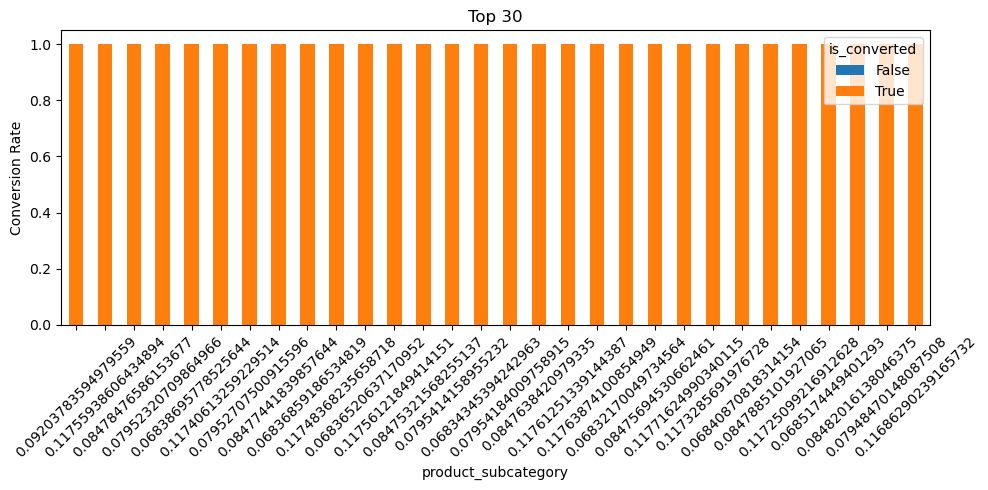

In [121]:
plot_top_conversion_rates(df_train, 'product_subcategory', 'is_converted', top_n=30)

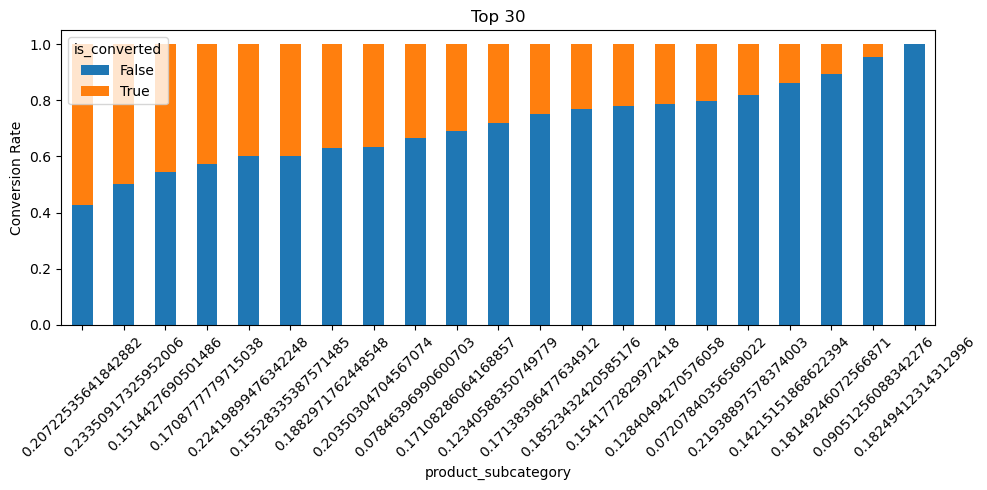

In [122]:
plot_top_conversion_rates(df_test, 'product_subcategory', 'is_converted', top_n=30)

# 12. product_category

In [123]:
categories = {
    'ultra stretch signage': 'DIGITAL Signage',
    'ultra stretch series': 'DIGITAL Signage',
    'signage': 'Signage',

    'led signage': 'LED Signage',
    'led aio 136': 'LED Signage',
    'meeting & screen sharedirect view leddirect view led': 'LED Signage',
    'laec015': 'LED Signage',
    'leadallin': 'LED Signage',
    'ledallinone': 'LED Signage',
    'laec015-gn.awz': 'LED Signage',
    'gscd046': 'LED Signage',
    'laec15': 'LED Signage',
    'lg led bloc': 'LED Signage',
    'lg magnit': 'LED Signage',
    'led cinema': 'LED Signage',
    'pantalla led outdoor': 'LED Signage',
    'gsca046': 'LED Signage',
    'gscd100': 'LED Signage',
    'lsca039': 'LED Signage',
    'essential series': 'LED Signage',

    'oled signage': 'OLED Signage',
    'transparent oled': 'OLED Signage',

    'uhd signage': 'DIGITAL Signage',
    'uh': 'DIGITAL Signage',

    'digital signage': 'DIGITAL Signage',
    'one:quick series': 'DIGITAL Signage',
    'lg one:quick': 'DIGITAL Signage',
    'lg one:quick series': 'DIGITAL Signage',
    'one quick works': 'DIGITAL Signage',
    'onequick series': 'DIGITAL Signage',
    'one quick:flex': 'DIGITAL Signage',
    'one:quick flex': 'DIGITAL Signage',
    'one:quick': 'DIGITAL Signage',
    '43uh5f-h.awzm': 'DIGITAL Signage',
    '49vl5g-m.awzm': 'DIGITAL Signage',
    'corpouh5f': 'DIGITAL Signage',
    'corpuh5f-': 'DIGITAL Signage',
    '86uh5f': 'DIGITAL Signage',
    '55tc3d': 'DIGITAL Signage',
    '5svh7f-a': 'DIGITAL Signage',
    'tr3': 'DIGITAL Signage',
    '98uh5e': 'DIGITAL Signage',
    'standard signage': 'DIGITAL Signage',
    'high brightness signage': 'DIGITAL Signage',
    'interactive signage': 'DIGITAL Signage',
    'special signage': 'DIGITAL Signage',
    'accessories': 'DIGITAL Signage',
    'standard': 'DIGITAL Signage',
    'high brightness': 'DIGITAL Signage',

    'tv signage': 'DIGITAL Signage',
    'smart tv signage': 'DIGITAL Signage',
    'ur640': 'DIGITAL Signage',
    'ur640s': 'DIGITAL Signage',

    'aio': 'AIO',
    'allinone_rmk': 'AIO',

    'system air conditioner': 'CAC',
    'single cac': 'CAC',
    'điều hòa trung tâm multi': 'CAC',
    'cac': 'CAC',
    'system ac': 'CAC',

    'vrf': 'VRF',
    'all lg vrf systems': 'VRF',
    'multi v5 vrf': 'VRF',
    'نظام التدفق المتغيرvrf': 'VRF',
    'vrf - multi v s': 'VRF',
    'kimatyzacja vrf': 'VRF',
    'điều hòa trung tâm vrf': 'VRF',
    'systèmes de débit à réfrigérant variable (drv)': 'VRF',

    'điều hòa trung tâm chiller': 'Chiller',
    'chiller': 'Chiller',
    'مبرد (تشيلر)': 'Chiller',
    'chiller/enfriadoras': 'Chiller',

    'software solution': 'Solution',
    'signage care solution': 'Solution',
    'signage care solutions': 'Solution',
    'lg home bliss air solution': 'Solution',
    'lg paradise air solution': 'Solution',
    'lg salang air solution for dream homes': 'Solution',
    'حلول التدفئة': 'Solution',
    'pro:centric': 'Solution',
    'pro centric hotel': 'Solution',
    'procentric': 'Solution',

    'heating': 'Heating',
    'חימום': 'Heating',
    'isıtma': 'Heating',
    'ogrzewanie (pompy ciepła)': 'Heating',
    'calefacción': 'Heating',
    'aquecimento': 'Heating',

    'rac': 'RAC',
    'điều hòa gia dụng': 'RAC',
    'เครื่องปรับอากาศเผื่อที่อยู่อาศัย': 'RAC',
    'ac rumah': 'RAC',
    'aire acondicionado residencial': 'RAC',
    'climatiseur résidentiel': 'RAC',
    'điều hòa cục bộ': 'RAC',
    'residential air conditioner': 'RAC',
    'מזגנים למקום מגורים': 'RAC',
    'تكييفات': 'RAC',
    'ar condicionado residencial': 'RAC',
     'pendingin': 'RAC',

    'commercial display': 'Display',
    'medical display': 'Display',
    '互動式顯示屏': 'Display',
    'led 顯示屏': 'Display',
    '標準顯示屏': 'Display',
    'collaboration displays': 'Display',
    'oled 顯示屏': 'Display',
    'window facing display': 'Display',
    'medical displays': 'Display',
    'radiology displays': 'Display',
    'taa lcd lfd displays': 'Display',
    '特別顯示屏': 'Display',
    '高亮度顯示屏': 'Display',

    'hotel tv': 'TV',
    'commercial tv': 'TV',
    'hospital tv': 'TV',
    'tv': 'TV',
    '酒店電視': 'TV',
    'tv,commercial tv': 'TV',
    'htv': 'TV',
    'tv 60"': 'TV',
    'comercial tv': 'TV',
    '醫院電視': 'TV',
    'ctv': 'TV',
    'smart tv': 'TV',
    'tv 55"': 'TV',
    'tv 43 pol': 'TV',
    '43us660h0sd.awz': 'TV',
    '50uq801c0sb.bwz': 'TV',
    '55us660h0sd.bwz': 'TV',
    '32lq621cbsb.awz': 'TV',
    '55uq801c0sb.bwz': 'TV',
    '43uq751c0sf.bwz': 'TV',
    '43uq751c0sb.bwz': 'TV',
    '50us660h0sd.bwz': 'TV',
    '43us660h (na)': 'TV',
    'hoteleria_us670h': 'TV',

    'monitor': 'Monitor',
    'computer monitors': 'Monitor',
    'medical monitors': 'Monitor',
    'monitor & pc': 'Monitor',
    'medical monitor': 'Monitor',
    'surgical monitor': 'Monitor',
    '28mq780': 'Monitor',
    'medical- surgical': 'Monitor',
    'monitorindustrial_rmk': 'Monitor',

    'multi-split': 'Multi Split',
    'multi split': 'Multi Split',
    'פיצול מרובה': 'Multi Split',
    'multi-split (plusieurs pièces)': 'Multi Split',
    'klimatyzacja multi-split': 'Multi Split',

    'single-split': 'Single Split',
    'single split': 'Single Split',
    'split tunggal': 'Single Split',

    'videowall_rmk': 'Video Wall',
    'videwall': 'Video Wall',
    '110 + video wall': 'Video Wall',
    'video wall': 'Video Wall',
    '49vl5g-m': 'Video Wall',
    '55vm5e-a': 'Video Wall',
    '55vm5j-h': 'Video Wall',
    '49vl5f': 'Video Wall',
    'videowall signage': 'Video Wall',

    'etc.': 'Other',
    'lainnya': 'Other',
    'אחר': 'Other',
    'ฯลฯ': 'Other',
    'khác': 'Other',
    'outros': 'Other',
    'آخر': 'Other',
    'not specified': 'Other',
    'other': 'Other',
    'others': 'Other',
    'otros': 'Other',
    'autre': 'Other',

    'idb': 'IDB',
    'interactive digital board': 'IDB',

     'washing machine,dryer': 'Several',
     'solar,chiller': 'Several',
     'system ac,rac': 'Several',
     'monitor signage,commercial tv,monior/monitor tv': 'Several',
     'monitor signage,monior/monitor tv': 'Several',
     'aircare,built-in/cooking': 'Several',
     'monitor signage,commercial tv,monior/monitor tv,projector,tv': 'Several',
     'monitor signage,commercial tv,monior/monitor tv,tv': 'Several',
     'commercial tv,tv': 'Several',
     'monitor signage,commercial tv,solar,ess,monior/monitor tv,pc,projector,robot,system ac,ems,rac,chill': 'Several',
     'monior/monitor tv,tv': 'Several',
     'chiller,aircare': 'Several',
     'solar,aircare': 'Several',
     'commercial tv,audio/video': 'Several',
     'solar,ess': 'Several',
     'solar,system ac': 'Several',
     'vrf,multi-split': 'Several',
     'vrf,multi-split,chiller': 'Several',
     'vrf,multi-split,single-split,chiller,heating': 'Several',
     'system ac,solar,washing machine': 'Several',
     'solar,ess,ems': 'Several',
     'tv,mobile': 'Several',
     'commercial tv,projector': 'Several',
     'aircare,water care': 'Several',
     'monior/monitor tv,chiller': 'Several',
     'system ac,chiller': 'Several',
     'system ac,aircare': 'Several',
     'monitor signage,commercial tv': 'Several',
     'system ac,tv': 'Several',
     'monitor signage,audio/video': 'Several',
     'monitor signage,commercial tv,solar,ess,monior/monitor tv,pc': 'Several',
     'monitor signage,pc': 'Several',
     'monitor signage,commercial tv,solar,ess': 'Several',
     'monior/monitor tv,system ac,tv,refrigerator,washing machine,dryer,built-in/cooking': 'Several',
     'commercial tv,robot': 'Several',
     'monitor signage,solar': 'Several',
     'solar,projector': 'Several',
     'tv,audio/video': 'Several',
     'solar,dryer': 'Several',
     'solar,monior/monitor tv': 'Several',
     'chiller,dryer': 'Several',
     'monior/monitor tv,pc': 'Several',
     'solar,refrigerator': 'Several',
     'monitor signage,system ac': 'Several',
     'system air conditioner,solar': 'Several',
     'solar,tv': 'Several',
     'monitor signage,tv': 'Several',
     'dryer,chiller': 'Several',
     'monitor signage,monior/monitor tv,system ac,vacuum cleaner,tv,home beauty,commercial tv,mobile,audio': 'Several',
     'solar,vacuum cleaner': 'Several',
     'solar,monior/monitor tv,pc,tv,refrigerator,washing machine,dryer,home beauty': 'Several',
     'monitor signage,solar,robot,water care': 'Several',
     'mobile,audio/video': 'Several',
     'system ac,refrigerator,washing machine,dryer': 'Several',
     'solar,system ac,aircare': 'Several',
     'projector,system ac,water care': 'Several',
     'chiller,water care': 'Several',
     'monior/monitor tv,tv,commercial tv,pc,refrigerator,solar,rac,washing machine,mobile,ess,audio/video': 'Several',
     'ess,chiller': 'Several',
     'monitor signage,monior/monitor tv,pc,tv': 'Several',
     'solar,water care': 'Several',
     'digital signage or commercial tvs': 'Several',
     'monitor signage,commercial tv,audio/video': 'Several',
     'solar,built-in/cooking': 'Several',
     'monitor signage,monior/monitor tv,commercial tv': 'Several',
     'commercial tv,monior/monitor tv': 'Several',
     'robot,system ac': 'Several',
     'commercial tv,water care': 'Several',
     'pc,washing machine': 'Several',
     'monitor signage,solar,monior/monitor tv,pc,projector,robot,system ac,tv,refrigerator,washing machine': 'Several',
     'system ac,tv,refrigerator,washing machine,built-in/cooking,audio/video': 'Several',
     'system air conditioner,energy storage system': 'Several',
     'system ac,home beauty': 'Several',
     'information display,monitor': 'Several',
     'rac/cac': 'Several',
     'system ac,chiller,aircare': 'Several',
     'tv,refrigerator,washing machine': 'Several',
     'monior/monitor tv,refrigerator': 'Several',
     'monior/monitor tv,system ac,tv,pc,refrigerator,water care,solar,washing machine,mobile,chiller,built': 'Several',
     'projector,audio/video': 'Several',
     'monior/monitor tv,audio/video': 'Several',
     'monitor signage,commercial tv,monior/monitor tv,pc,tv,home beauty,audio/video': 'Several',
     'pc,robot,system ac,chiller,tv,refrigerator,washing machine,vacuum cleaner,styler,dryer,mobile,audio/': 'Several',
     'refrigerator,washing machine,built-in/cooking': 'Several',
     'monitor signage,monior/monitor tv,tv,audio/video': 'Several',
     'tv,refrigerator,washing machine,vacuum cleaner,audio/video': 'Several',
     'pc,tv': 'Several',
     'aircare,mobile': 'Several',
     'solar,ess,system ac': 'Several',
     'system ac,refrigerator': 'Several',
     'tv,pc': 'Several',
     'monitor signage,commercial tv,solar,pc,projector,system ac,ems,rac,chiller,refrigerator,washing mach': 'Several',
     'chiller,refrigerator': 'Several',
     'monitor signage,commercial tv,solar,projector,robot,chiller,refrigerator,built-in/cooking,water care': 'Several',
     'commercial tv,solar': 'Several',
     'monior/monitor tv,projector,audio/video': 'Several',
     'refrigerator,chiller': 'Several',
     'chiller,tv': 'Several',
     'projector,ems': 'Several',
     'vrf,chiller': 'Several',
     'monitor signage,mobile': 'Several',
     'robot,vacuum cleaner': 'Several',
     'monitor signage,commercial tv,monior/monitor tv,audio/video': 'Several',
     'video wall + aio': 'Several',
     'vrf,single-split': 'Several',
     'vrf,multi-split,single-split,chiller,etc.': 'Several',
     'multi-split,single-split': 'Several',
     'vrf,multi-split,single-split': 'Several',
     'vrf,multi-split,etc.': 'Several',
     'vrf,multi-split,heating': 'Several',
     'vrf,multi-split,single-split,chiller': 'Several',
     'vrf,multi-split,single-split,heating': 'Several',
     'vrf,single-split,chiller': 'Several',
     'commercial tv,solar,ess,projector,system ac,tv,washing machine,home beauty,audio/video': 'Several',
     'solar,robot': 'Several',
     'monitor signage,commercial tv,monior/monitor tv,pc,projector,tv,audio/video': 'Several',
     'solar,energy storage system': 'Several',
     'system ac,solar': 'Several',
     'solar,system ac,water care': 'Several',
     'vrf,heating': 'Several',
     'monitor signage,monior/monitor tv,vacuum cleaner,tv,home beauty,commercial tv,pc,refrigerator,styler': 'Several',
     'refrigerator,built-in/cooking': 'Several',
     'ems,audio/video': 'Several',
     'projector,ems,mobile,audio/video': 'Several',
     'commercial tv,solar,ess,monior/monitor tv,pc,projector,robot,system ac,ems,rac,chiller,refrigerator,': 'Several',
     'tv,refrigerator': 'Several',
     'monior/monitor tv,refrigerator,audio/video': 'Several'
}

# 주어진 값을 카테고리에 따라 변환
def map_to_category(value):
    return categories.get(value, value)

# 판다스 시리즈를 입력으로 받아 카테고리에 따라 변환된 값을 반환
def transform_column_values_series(column_series):
    return column_series.map(map_to_category)


# 변환된 칼럼 값 출력
df_train['product_category'] = transform_column_values_series(df_train['product_category'])
df_test['product_category'] = transform_column_values_series(df_test['product_category'])

In [124]:
count_1 = (df_train['product_category'].value_counts() == 1).sum()
print(f"빈도수가 1인 행의 개수: {count_1}")

빈도수가 1인 행의 개수: 19


In [125]:
df_train['product_category']= df_train['product_category'].fillna('None')
df_test['product_category']= df_test['product_category'].fillna('None')

In [126]:
df_train['product_category'].value_counts()

product_category
None                        19374
IDB                          6185
VRF                          5736
DIGITAL Signage              5615
Multi Split                  3683
                            ...  
32 / 43 pol                     1
high inch 86 / 98 or 110        1
refrigerator                    1
aio | one quick                 1
parts                           1
Name: count, Length: 75, dtype: int64

In [127]:
counts = df_train['product_category'].value_counts()
threshold = 11
low_frequency = counts[counts < threshold].index
df_train['product_category'] = df_train['product_category'].replace(low_frequency, 'Other')

In [128]:
df_train['product_category'].value_counts()

product_category
None                            19374
IDB                              6185
VRF                              5736
DIGITAL Signage                  5615
Multi Split                      3683
Other                            2257
video wall signage               2029
LED Signage                      1939
RAC                              1770
Single Split                     1576
TV                               1371
OLED Signage                     1352
Display                          1121
Chiller                          1057
Monitor                           807
Heating                           713
ventilation                       420
Solution                          366
Several                           323
teto ou cassete inverter          308
control                           263
multi inverter                    257
webos                             144
Video Wall                        122
pc                                114
projector                        

In [129]:
df_test['product_category'].value_counts()

product_category
None                  1858
VRF                    726
DIGITAL Signage        595
Multi Split            544
LED Signage            289
Other                  207
Single Split           179
video wall signage     167
TV                     144
OLED Signage           104
Chiller                 99
IDB                     74
Heating                 67
Monitor                 58
Display                 32
ventilation             31
Solution                22
cloud device            18
webos                   14
laptop                  13
control                 13
projector               12
ess                      4
notebook                 1
Name: count, dtype: int64

In [130]:
counts = df_test['product_category'].value_counts()
threshold = 10
low_frequency = counts[counts < threshold].index
df_test['product_category'] = df_test['product_category'].replace(low_frequency, 'Other')

In [131]:
# train에 없는 값이 test에 있을까? 

train_vals = set(df_train['product_category'].unique())
test_vals = set(df_test['product_category'].unique())

test_not_train = test_vals - train_vals

print(test_not_train) 

set()


In [132]:
from category_encoders import CatBoostEncoder

# CatBoost 인코딩
catboost_encoder = CatBoostEncoder()

df_train['product_category'] = catboost_encoder.fit_transform(df_train['product_category'], df_train['is_converted'])
df_test['product_category'] = catboost_encoder.transform(df_test['product_category'])



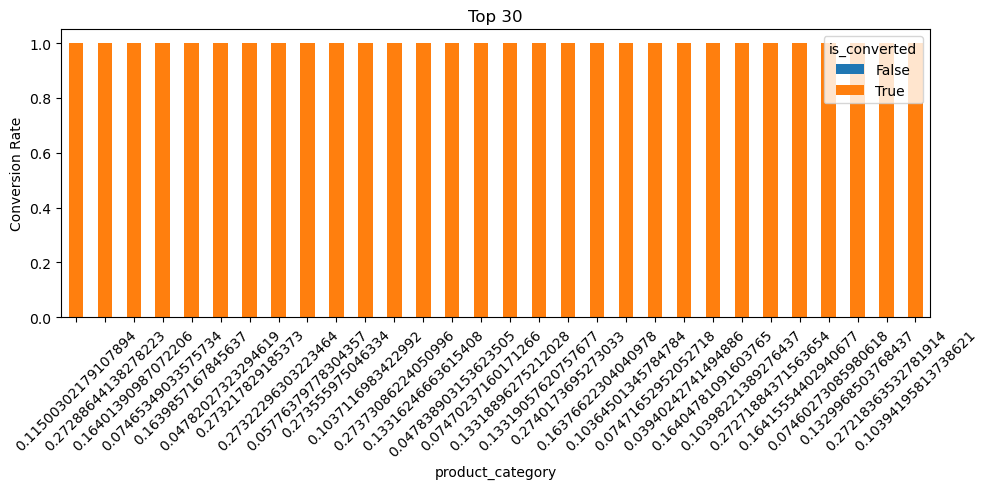

In [133]:
plot_top_conversion_rates(df_train, 'product_category', 'is_converted', top_n=30)

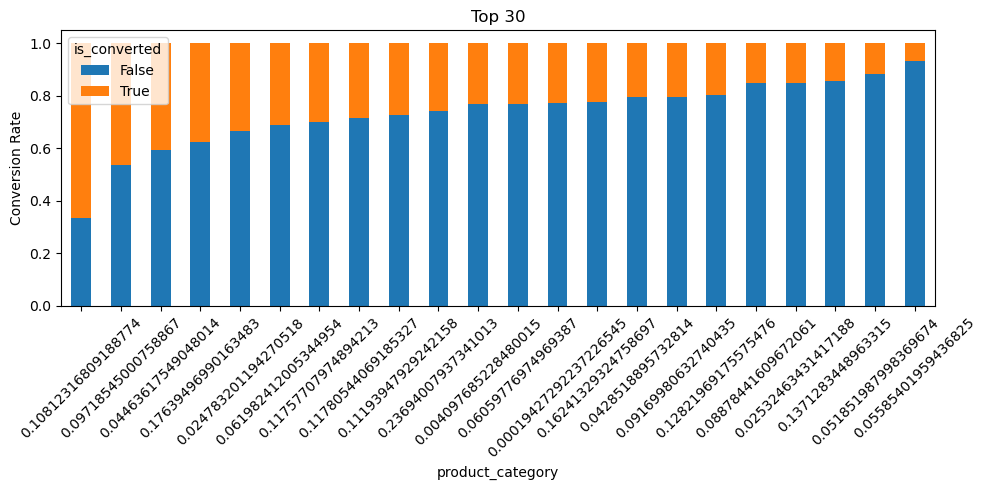

In [134]:
plot_top_conversion_rates(df_test, 'product_category', 'is_converted', top_n=30)

In [135]:
# 1

# 13. inquiry_type
- inquiry_type	고객의 문의 유형

In [136]:
df_train['inquiry_type'].value_counts()

inquiry_type
Quotation or purchase consultation                                                                                     23274
Quotation or Purchase Consultation                                                                                     18766
Sales Inquiry                                                                                                           9977
Product Information                                                                                                     1237
Other                                                                                                                    929
                                                                                                                       ...  
quotation_                                                                                                                 1
display product                                                                                                 

/var/folders/zn/z7q7zstd5jg_tg51vl5zplj80000gn/T/ipykernel_68401/3047464898.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


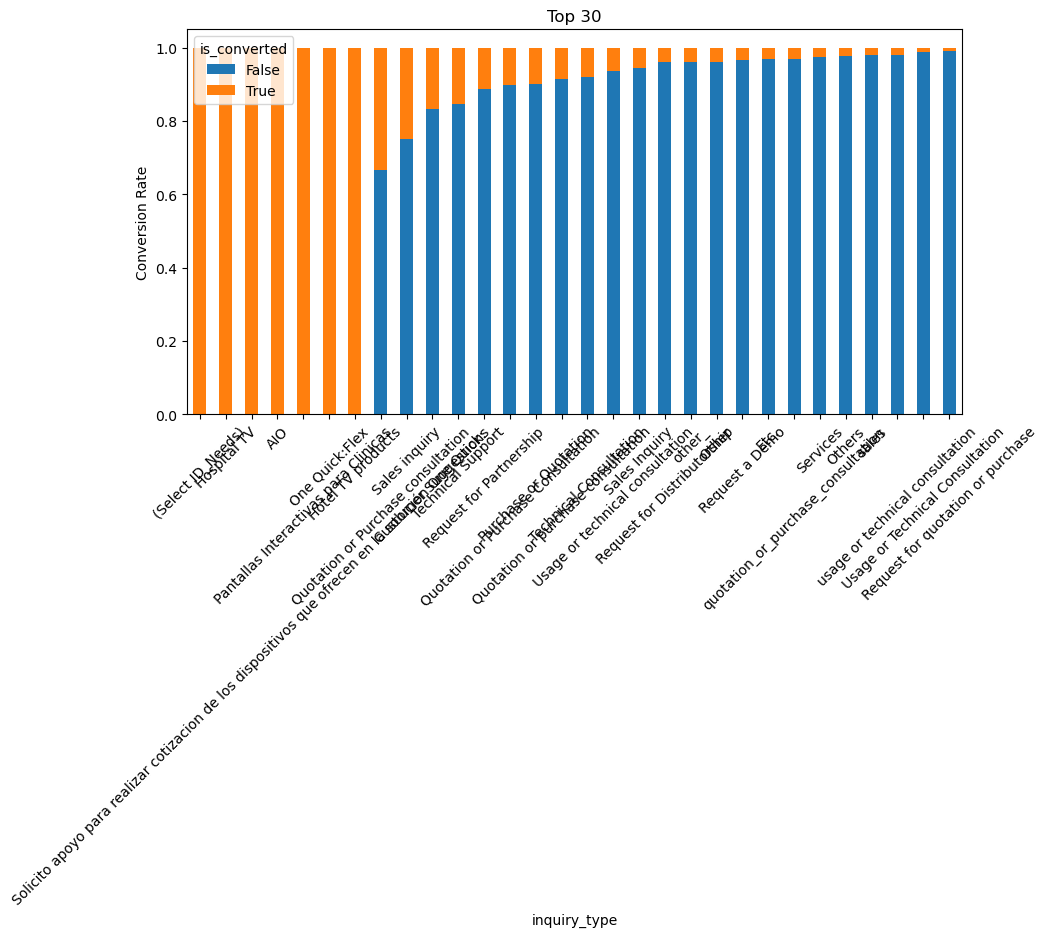

In [137]:
plot_top_conversion_rates(df_train, 'inquiry_type', 'is_converted', top_n=30)

In [138]:
# 주어진 값들을 범주에 따라 매핑하는 딕셔너리 생성
category_mapping = {
    'Quotation or purchase consultation': 'Quotation',
    'Quotation or Purchase Consultation': 'Quotation',
    'quotation_or_purchase_consultation': 'Quotation',
    'Request for quotation or purchase': 'Quotation',
    'Quotation or Purchase consultation': 'Quotation',
    'Purchase': 'Quotation',
    'quotation_': 'Quotation',
    'Purchase or Quotation': 'Quotation',
    'first Info and pricing': 'Quotation',
    'Hola me pueden cotizar 19 pantallas interactivas de 100 pulgadas entregadas en Guayaquil -Ecuador.': 'Quotation',
    'Vui lòng báo giá giúp mình sản phẩm đo thân nhiệt Xin cảm ơn': 'Quotation',
    'Probeam precio': 'Quotation',
    'Solicito apoyo para realizar cotizacion de los dispositivos que ofrecen en la solución\xa0One Quick:\xa0': 'Quotation',
    'Toi muon tim hieu thong tin ky thuat, gia ca cua sp de su dung': 'Quotation',
    'tôi cần tham khảo giá và giải pháp từ LG': 'Quotation',
    
    'Product Information': 'Product',
    'One Quick:Flex': 'Product',
    'AIO': 'Product',
    'Hospital TV': 'Product',
    'EDUCATIONAL EQUIPMENTS': 'Product',
    'Digital platform': 'Product',
    'TV interactive': 'Product',
    'Display Textbook and photos': 'Product',
    'High inch 86 / 98 or 110': 'Product',
    'display product': 'Product',
    'estoy buscando para Ecuador este producto LG MAGNIT micro LED, para un cliente de 138 pulgadas, con envió marítimo.': 'Product',
    'Hotel TV products': 'Product',
    'Pantallas Interactivas para Clinicas': 'Product',
    'IDB': 'Product',
    'LED Signage': 'Product',
    'Standalone': 'Product',
    'Video Wall': 'Product',
    'Preciso de um monitor médico para radiografia convencional e tomogrtafia.': 'Product',
    'VRF': 'Product',
    'window facing product': 'Product',
    
    'Usage or technical consultation': 'Technical',
    'Technical Support': 'Technical',
    'Usage or Technical Consultation': 'Technical',
    'Technical Consultation': 'Technical',
    'technical': 'Technical',
    'usage or technical consultation': 'Technical',
    'usage_or_technical_consultation': 'Technical',
    'Request for technical consulting': 'Technical',
    'technical_consultation': 'Technical',
    
    'Other': 'Other',
    'Etc.': 'Other',
    'other': 'Other',
    'other_': 'Other',
    'Others': 'Other',
    'others': 'Other',
    'ETC.': 'Other',
    'Not specified': 'Other',
    
    'Event Inquiry': 'Event',
    'Evento_SdelEstero': 'Event'
}

# 주어진 값을 카테고리에 따라 변환
def map_to_category(value):
    return category_mapping.get(value, value)

# 판다스 시리즈를 입력으로 받아 카테고리에 따라 변환된 값을 반환
def transform_column_values_series(column_series):
    return column_series.map(map_to_category)


# 변환된 칼럼 값 출력
df_train['inquiry_type'] = transform_column_values_series(df_train['inquiry_type'])
df_test['inquiry_type'] = transform_column_values_series(df_test['inquiry_type'])

In [139]:
counts = df_train['inquiry_type'].value_counts()
threshold = 13
low_frequency = counts[counts < threshold].index
df_train['inquiry_type'] = df_train['inquiry_type'].replace(low_frequency, 'Other')

In [140]:
counts = df_test['inquiry_type'].value_counts()
threshold = 13
low_frequency = counts[counts < threshold].index
df_test['inquiry_type'] = df_test['inquiry_type'].replace(low_frequency, 'Other')

In [141]:
df_train['inquiry_type'].value_counts()

inquiry_type
Quotation                      42395
Sales Inquiry                   9977
Technical                       1778
Other                           1437
Product                         1266
Trainings                        434
Services                         415
Request for Partnership          297
Request a Demo                   184
sales                            100
Request for Distributorship       75
Name: count, dtype: int64

In [143]:
# train에 없는 값이 test에 있을까? 

train_vals = set(df_train['inquiry_type'].unique())
test_vals = set(df_test['inquiry_type'].unique())

test_not_train = test_vals - train_vals

print(test_not_train) 

set()


In [144]:
# 'customer_idx' 열의 데이터 타입 확인
print(df_train['inquiry_type'].dtype)

# 'customer_idx' 열을 범주형으로 변환 (만약 int64일 경우)!!!!?
df_train['inquiry_type'] = df_train['inquiry_type'].astype(str)
df_test['inquiry_type'] = df_test['inquiry_type'].astype(str)

# CatBoost 인코딩
catboost_encoder = CatBoostEncoder()

df_train['inquiry_type'] = catboost_encoder.fit_transform(df_train['inquiry_type'], df_train['is_converted'])
df_test['inquiry_type'] = catboost_encoder.transform(df_test['inquiry_type'])




object


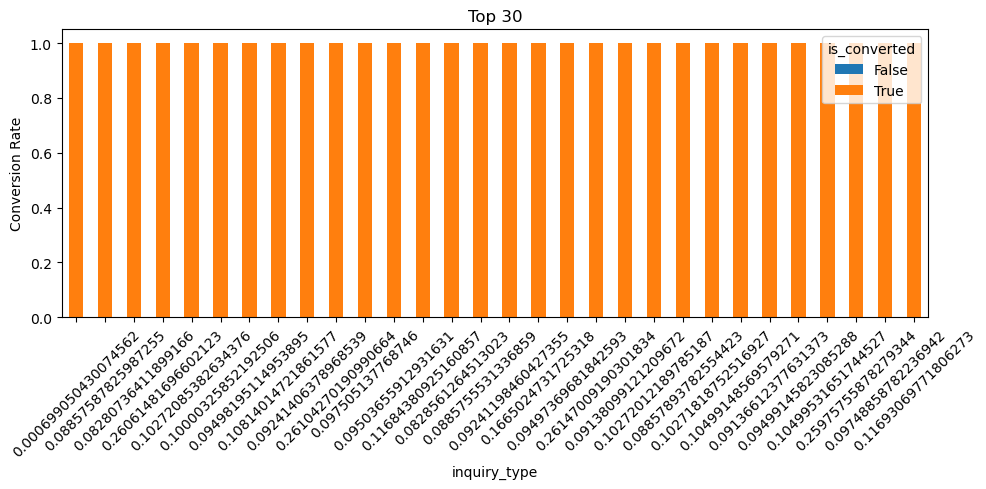

In [145]:
plot_top_conversion_rates(df_train, 'inquiry_type', 'is_converted', top_n=30)

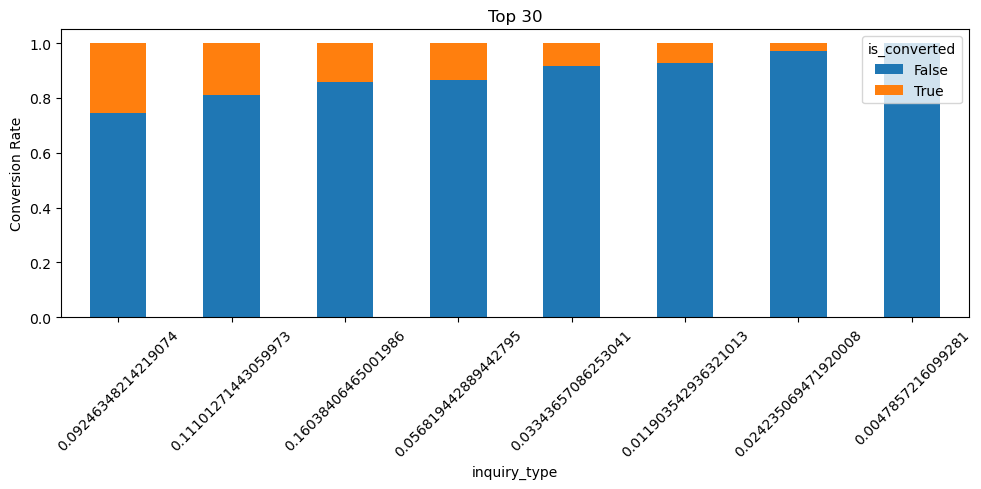

In [146]:
plot_top_conversion_rates(df_test, 'inquiry_type', 'is_converted', top_n=30)

# 14. response_corporate
- 	담당 자사 법인명

In [147]:
df_train['response_corporate'].isnull().sum()

0

In [148]:
df_train['response_corporate'].value_counts()

response_corporate
LGEIL    16908
LGESP     9311
LGEUS     5955
LGEMS     2768
LGEPH     2651
LGEGF     2149
LGECB     2079
LGEUK     1651
LGESJ     1469
LGECL     1339
LGEPS     1252
LGEIS     1146
LGEPR     1131
LGEDG     1051
LGEPL      850
LGEEG      704
LGEVH      614
LGEES      592
LGETK      541
LGEAR      491
LGEKR      433
LGEHK      383
LGEAP      366
LGESL      348
LGEMK      331
LGEFS      302
LGEAF      288
LGEIN      281
LGELF      274
LGESA      268
LGECI      263
LGETH      185
LGEEF      159
LGEPT      111
LGEML      110
LGEBN       99
LGEYK       78
LGECH       65
LGEHS       51
LGETT       47
LGEJP       41
LGEAS       33
LGESW       31
LGEMC       30
LGERO       29
LGEEB       13
LGEAG        8
LGERA        8
LGECZ        7
LGELA        2
LGEUR        1
LGEIR        1
LGEBT        1
Name: count, dtype: int64

In [149]:
counts = df_train['response_corporate'].value_counts()
threshold = 10
low_frequency = counts[counts < threshold].index
df_train['response_corporate'] = df_train['response_corporate'].replace(low_frequency, 'Other')

In [150]:
counts = df_test['response_corporate'].value_counts()
threshold = 10
low_frequency = counts[counts < threshold].index
df_test['response_corporate'] = df_test['response_corporate'].replace(low_frequency, 'Other')

In [151]:
# train에 없는 값이 test에 있을까? 

train_vals = set(df_train['response_corporate'].unique())
test_vals = set(df_test['response_corporate'].unique())

test_not_train = test_vals - train_vals

print(test_not_train) 

set()


In [152]:

# CatBoost 인코딩
catboost_encoder = CatBoostEncoder()

df_train['response_corporate'] = catboost_encoder.fit_transform(df_train['response_corporate'], df_train['is_converted'])
df_test['response_corporate'] = catboost_encoder.transform(df_test['response_corporate'])


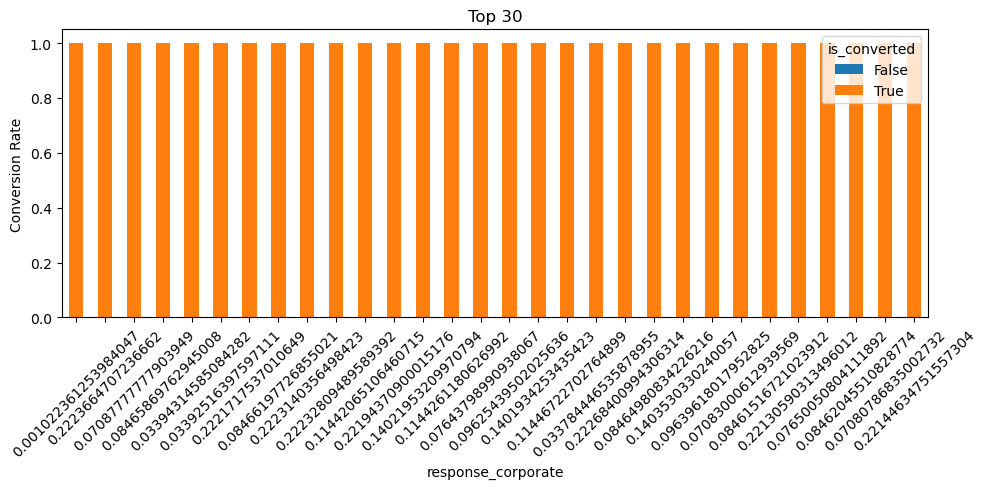

In [153]:
plot_top_conversion_rates(df_train, 'response_corporate', 'is_converted', top_n=30)

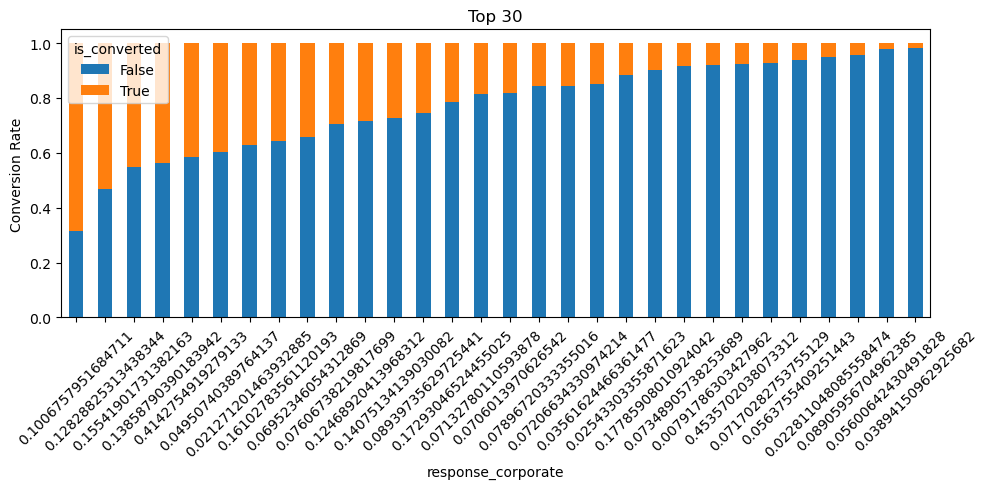

In [154]:
plot_top_conversion_rates(df_test, 'response_corporate', 'is_converted', top_n=30)

# 15. expected_timeline

In [155]:
def update_expected_timeline(value):
    if pd.notna(value):
        original_value = value
        mapping_rules = {
            ('requi', 'reqi'): 'requirement',
            ('no', 'not'): 'no requirement',
            ('follow',): 'follow',
            ('details',): 'details shared',
            ('call back', 'call later', 'call after'): 'call back'
        }
        for keywords, updated_value in mapping_rules.items():
            if any(keyword in value for keyword in keywords):
                return updated_value
        return original_value


def mapping(df, timeline_mapping):
    df['expected_timeline'] = df['expected_timeline'].apply(update_expected_timeline)
    df['expected_timeline'] = df['expected_timeline'].map(timeline_mapping).fillna(df['expected_timeline'])
    return df

timeline_mapping = {
    "less than 3 months": "0-3m",
    "less_than_3_months": "0-3m",
    
    "3 months ~ 6 months": "3-6m",
    "3_months_~6_months": "3-6m",
    "3_months_~_6_months": "3-6m",
    
    "6 months ~ 9 months": "6-9m",
    "6_months~9_months": "6-9m",
    
    "9 months ~ 1 year": "9-12m",
    "9_months~_1_year": "9-12m",
    "9_months_~_1_year": "9-12m",
    
    "up to december": "1y",
    "more than a year": "1y",
    "more_than_a_year": "1y",
    
    "couldn't connect": "no response",
    "didn't respond": "no response",
    "rnr": "no response",
    "reponse": "response"
}


df_train = mapping(df_train, timeline_mapping)
df_test = mapping(df_test, timeline_mapping)

# nan을 'no requirement'로 채우기
df_train['expected_timeline'].fillna('no requirement', inplace=True)
df_test['expected_timeline'].fillna('no requirement', inplace=True)


In [156]:
df_train['expected_timeline'].value_counts()

expected_timeline
no requirement                                                                                                                  30983
0-3m                                                                                                                            17326
3-6m                                                                                                                             5035
1y                                                                                                                               3028
9-12m                                                                                                                            1107
                                                                                                                                ...  
received po.                                                                                                                        1
september                                   

In [157]:
counts = df_train['expected_timeline'].value_counts()
threshold = 10
low_frequency = counts[counts < threshold].index
df_train['expected_timeline'] = df_train['expected_timeline'].replace(low_frequency, 'Other')

In [158]:
df_train['expected_timeline'].value_counts()

expected_timeline
no requirement        30983
0-3m                  17326
3-6m                   5035
1y                     3028
9-12m                  1107
6-9m                   1098
Other                   220
requirement             112
follow                  108
less than 6 months      108
etc.                     95
details shared           45
no response              17
call back                17
Name: count, dtype: int64

In [159]:
df_test['expected_timeline'].value_counts()

expected_timeline
no requirement    2408
0-3m              1734
3-6m               426
1y                 272
9-12m              264
6-9m               167
Name: count, dtype: int64

In [160]:
# TargetEncoder 적용
target_encoder = CatBoostEncoder()
df_train['expected_timeline'] = target_encoder.fit_transform(df_train['expected_timeline'], df_train['is_converted'])
df_test['expected_timeline'] = target_encoder.transform(df_test['expected_timeline'])  # 'transform'만 호출하여 새로운 데이터에 적용



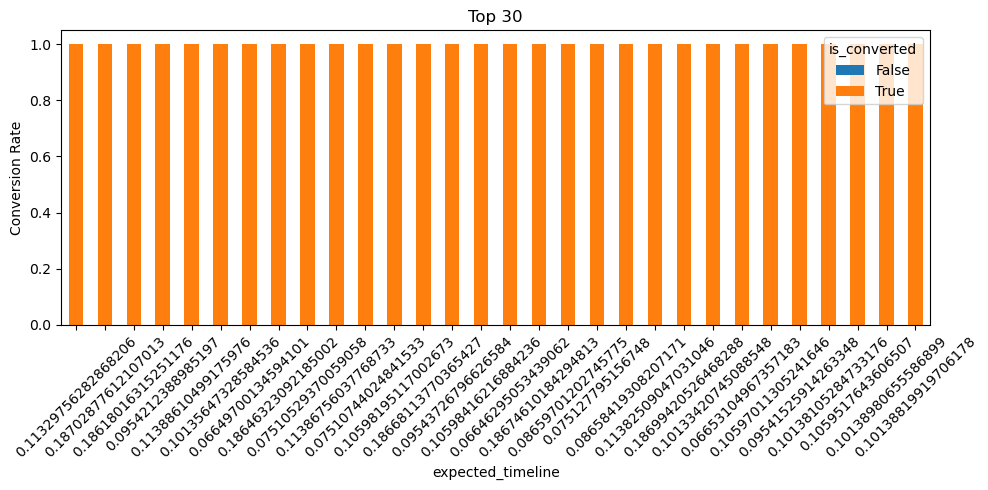

In [161]:
plot_top_conversion_rates(df_train, 'expected_timeline', 'is_converted', top_n=30)

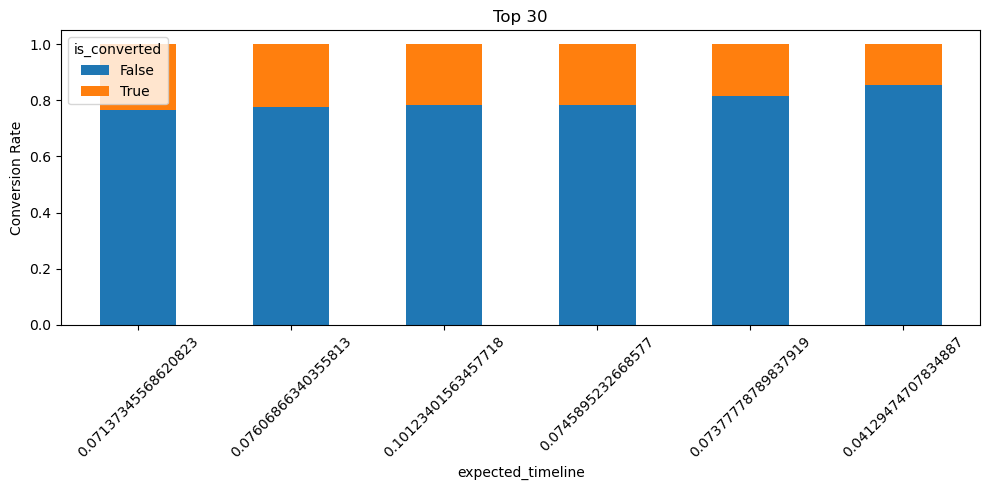

In [162]:
plot_top_conversion_rates(df_test, 'expected_timeline', 'is_converted', top_n=30)

# business area, subarea

In [163]:
print(df_train['business_area'].isnull().sum())
print('-'*10)
print(df_test['business_area'].isnull().sum())
print('-'*10)
print(df_train['business_area'].value_counts())
print('-'*10)
print(df_test['business_area'].value_counts())

40882
----------
2898
----------
business_area
corporate / office                4097
retail                            3011
hotel & accommodation             2013
special purpose                   1929
residential (home)                1818
education                         1727
hospital & health care            1199
factory                           1035
government department              650
public facility                    519
transportation                     306
power plant / renewable energy     113
Name: count, dtype: int64
----------
business_area
corporate / office                581
transportation                    431
retail                            318
education                         312
hotel & accommodation             177
hospital & health care            133
residential (home)                124
special purpose                    93
factory                            77
public facility                    48
government department              48
power plant / re

In [164]:
print(df_train['business_subarea'].isnull().sum())
print('-'*10)
print(df_test['business_subarea'].isnull().sum())
print('-'*10)
print(df_train['business_subarea'].value_counts())
print('-'*10)
print(df_test['business_subarea'].value_counts())

53773
----------
3455
----------
business_subarea
Others                           1740
Other Stores                      280
Hospital                          267
Manufacturing Factory / Plant     196
Construction                      191
                                 ... 
Duty Free Shop                      2
Dormitory                           1
Casino Resort                       1
Holdings                            1
Travel Agency                       1
Name: count, Length: 86, dtype: int64
----------
business_subarea
Others                                     667
Hotel                                      123
Higher Education (College & University)    111
Other Stores                                82
K12 Kindergarten & Schools                  80
                                          ... 
Travel Agency                                1
Aerospace                                    1
Botanical Garden / Green House               1
Sea Passenger Terminal / Port              

In [165]:
# df_train
grouped_data_train = df_train.groupby('business_area')['business_subarea'].apply(list)
mode_subarea_by_area_train = df_train.groupby('business_area')['business_subarea'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df_train['business_subarea'] = df_train.apply(lambda row: mode_subarea_by_area_train.get(row['business_area'], row['business_subarea']), axis=1)

# df_test
grouped_data_test = df_test.groupby('business_area')['business_subarea'].apply(list)
mode_subarea_by_area_test = df_test.groupby('business_area')['business_subarea'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df_test['business_subarea'] = df_test.apply(lambda row: mode_subarea_by_area_test.get(row['business_area'], row['business_subarea']), axis=1)

In [166]:
print(df_train['business_subarea'].isnull().sum())
print('-'*10)
print(df_test['business_subarea'].isnull().sum())
print('-'*10)
print(df_train['business_subarea'].value_counts())
print('-'*10)
print(df_test['business_subarea'].value_counts())

40882
----------
2898
----------
business_subarea
Others                                     8050
Other Stores                               3011
Cruise                                     2013
Villa / Single-Family Home                 1818
Higher Education (College & University)    1727
Manufacturing Factory / Plant              1035
General Government Office                   650
Renewable Energy                            113
Name: count, dtype: int64
----------
business_subarea
Others                                     1153
Other Stores                                318
Higher Education (College & University)     312
Hotel                                       177
Hospital                                    133
Villa / Single-Family Home                  124
Manufacturing Factory / Plant                77
General Government Office                    48
Power Plant                                  31
Name: count, dtype: int64


# 16. ver_cus,ver_pro

In [167]:
print(df_train['ver_cus'].isnull().sum())
print('-'*10)
print(df_test['ver_cus'].isnull().sum())
print('-'*10)
print(df_train['ver_cus'].value_counts())
print('-'*10)
print(df_test['ver_cus'].value_counts())

0
----------
0
----------
ver_cus
0    56832
1     2467
Name: count, dtype: int64
----------
ver_cus
0    4497
1     774
Name: count, dtype: int64


In [168]:
print(df_train['ver_pro'].isnull().sum())
print('-'*10)
print(df_test['ver_pro'].isnull().sum())
print('-'*10)
print(df_train['ver_pro'].value_counts())
print('-'*10)
print(df_test['ver_pro'].value_counts())

0
----------
0
----------
ver_pro
0    56286
1     3013
Name: count, dtype: int64
----------
ver_pro
0    4842
1     429
Name: count, dtype: int64


# 17. ver_win_rate_x 
- ver_win_rate_x : 전체 Lead 중에서 Vertical을 기준으로 Vertical 수 비율과 Vertical 별 Lead 수 대비 영업 전환 성공 비율 값을 곱한 값


In [169]:
print(df_train['ver_win_rate_x'].isnull().sum())
print('-'*10)
print(df_test['ver_win_rate_x'].isnull().sum())
print('-'*10)
print(df_train['ver_win_rate_x'].value_counts())
print('-'*10)
print(df_test['ver_win_rate_x'].value_counts())

40882
----------
2898
----------
ver_win_rate_x
0.003079    4097
0.001183    3011
0.000717    2013
0.000543    1929
0.000298    1818
0.000572    1727
0.000060    1199
0.000215    1035
0.000097     650
0.000026     519
0.000013     306
0.000002     113
Name: count, dtype: int64
----------
ver_win_rate_x
0.003079    581
0.000013    431
0.001183    318
0.000572    312
0.000717    177
0.000060    133
0.000298    124
0.000543     93
0.000215     77
0.000026     48
0.000097     48
0.000002     31
Name: count, dtype: int64


In [170]:
#카이 제곱확인
from scipy.stats import chi2_contingency

# 'business_area'와 'ver_win_rate_x' 간의 교차테이블 생성
cross_tab = pd.crosstab(df_train['business_area'], df_train['ver_win_rate_x'])

# 카이제곱 검정 수행
chi2_stat, p_value, _, _ = chi2_contingency(cross_tab)

print(f"Chi-squared Statistic: {chi2_stat}")
print(f"P-value: {p_value}")


Chi-squared Statistic: 202587.0
P-value: 0.0


In [171]:
# business_unit과 business_area에 따라 모두 같은 값을 가지는지 확인
unique_counts = df_train.groupby(['business_unit', 'business_area'])['ver_win_rate_x'].nunique()
all_same_ver_win_rate_x = (unique_counts == 1)

for idx, is_same in enumerate(all_same_ver_win_rate_x):
    bu = unique_counts.index[idx][0]
    area = unique_counts.index[idx][1]
    print(f" '{bu}''{area}': {is_same}")



 'AS''corporate / office': True
 'AS''education': True
 'AS''factory': True
 'AS''government department': True
 'AS''hospital & health care': True
 'AS''hotel & accommodation': True
 'AS''power plant / renewable energy': True
 'AS''public facility': True
 'AS''residential (home)': True
 'AS''retail': True
 'AS''special purpose': True
 'AS''transportation': True
 'ID''corporate / office': True
 'ID''education': True
 'ID''factory': True
 'ID''government department': True
 'ID''hospital & health care': True
 'ID''hotel & accommodation': True
 'ID''power plant / renewable energy': True
 'ID''public facility': True
 'ID''residential (home)': True
 'ID''retail': True
 'ID''special purpose': True
 'ID''transportation': True
 'IT''corporate / office': True
 'IT''education': True
 'IT''factory': True
 'IT''government department': True
 'IT''hospital & health care': True
 'IT''hotel & accommodation': True
 'IT''power plant / renewable energy': True
 'IT''public facility': True
 'IT''residential

In [172]:
# 사업영역의 고유 수 와 ver_win_rate_x 의 고유수가 같음
df_train['business_area'].nunique(), df_test['ver_win_rate_x'].nunique()

(12, 12)

### business_unit  business_area 에 따라 모두 같은 값을 갖기 때문에 변수 설명력이 약함 -> 삭제해도될듯?

In [173]:
df_train.drop('ver_win_rate_x', axis=1, inplace=True)
df_test.drop('ver_win_rate_x', axis=1, inplace=True)

# 18. ver_win_ratio_per_bu
- ver_win_ratio_per_bu: 특정 Vertical Level1의 Business Unit 별 샘플 수 대비 영업 전환된 샘플 수의 비율을 계산

In [174]:
print(df_train['ver_win_ratio_per_bu'].isnull().sum())
print('-'*10)
print(df_test['ver_win_ratio_per_bu'].isnull().sum())
print('-'*10)
print(df_train['ver_win_ratio_per_bu'].value_counts())
print('-'*10)
print(df_test['ver_win_ratio_per_bu'].value_counts())

43995
----------
3365
----------
ver_win_ratio_per_bu
0.064566    2460
0.049840    2028
0.020121    1365
0.048630    1356
0.026846    1278
0.064070    1075
0.071345     984
0.011583     788
0.022634     713
0.060924     540
0.079412     421
0.036913     403
0.035484     385
0.031579     271
0.053571     216
0.051471     210
0.028777     200
0.022727     173
0.128571     156
0.131148     148
0.227273      62
0.285714      43
0.034483      29
Name: count, dtype: int64
----------
ver_win_ratio_per_bu
0.064566    443
0.048630    287
0.049840    211
0.071345    150
0.053571    139
0.011583     89
0.026846     87
0.020121     72
0.064070     71
0.131148     60
0.060924     49
0.035484     48
0.079412     37
0.031579     35
0.128571     26
0.036913     25
0.285714     22
0.022634     16
0.051471     14
0.028777      9
0.227273      9
0.022727      7
Name: count, dtype: int64


In [175]:
# business_unit과 business_area에 따라 모두 같은 값을 가지는지 확인
unique_counts = df_train.groupby(['business_unit', 'business_area'])['ver_win_ratio_per_bu'].nunique()
all_same_ver_win_rate_x = (unique_counts == 1)

for idx, is_same in enumerate(all_same_ver_win_rate_x):
    bu = unique_counts.index[idx][0]
    area = unique_counts.index[idx][1]
    print(f" {is_same}")


 True
 True
 True
 True
 True
 False
 True
 True
 True
 True
 True
 False
 True
 True
 True
 True
 True
 True
 True
 True
 True
 True
 True
 True
 False
 False
 False
 False
 False
 False
 False
 False
 False
 False
 False
 False
 True
 False
 False
 False
 False
 False
 False
 False
 False
 False


In [176]:
# all_same_ver_win_rate_x가 False인 경우 해당 그룹에서 'ver_win_ratio_per_bu' 값이 NaN인지 확인
for idx, is_same in enumerate(all_same_ver_win_rate_x):
    if not is_same:
        bu = unique_counts.index[idx][0]
        area = unique_counts.index[idx][1]
        
        nan_count = df_train[(df_train['business_unit'] == bu) & (df_train['business_area'] == area)]['ver_win_ratio_per_bu'].isna().sum()
        
        print(f"For business_unit '{bu}' and business_area '{area}': {nan_count}  NaN ")


For business_unit 'AS' and business_area 'hotel & accommodation': 207  NaN 
For business_unit 'AS' and business_area 'transportation': 53  NaN 
For business_unit 'IT' and business_area 'corporate / office': 330  NaN 
For business_unit 'IT' and business_area 'education': 150  NaN 
For business_unit 'IT' and business_area 'factory': 83  NaN 
For business_unit 'IT' and business_area 'government department': 49  NaN 
For business_unit 'IT' and business_area 'hospital & health care': 895  NaN 
For business_unit 'IT' and business_area 'hotel & accommodation': 791  NaN 
For business_unit 'IT' and business_area 'power plant / renewable energy': 8  NaN 
For business_unit 'IT' and business_area 'public facility': 40  NaN 
For business_unit 'IT' and business_area 'residential (home)': 42  NaN 
For business_unit 'IT' and business_area 'retail': 163  NaN 
For business_unit 'IT' and business_area 'special purpose': 108  NaN 
For business_unit 'IT' and business_area 'transportation': 33  NaN 
For bus

### ! false는 NAN값이다. 즉 business_unit과 business_area에 따라 모두 같은 값을 가지며, false인 경우는 nan값이다.

In [177]:
df_train['ver_win_ratio_per_bu'] = df_train['ver_win_ratio_per_bu'].fillna(0)
df_test['ver_win_ratio_per_bu'] = df_test['ver_win_ratio_per_bu'].fillna(0)

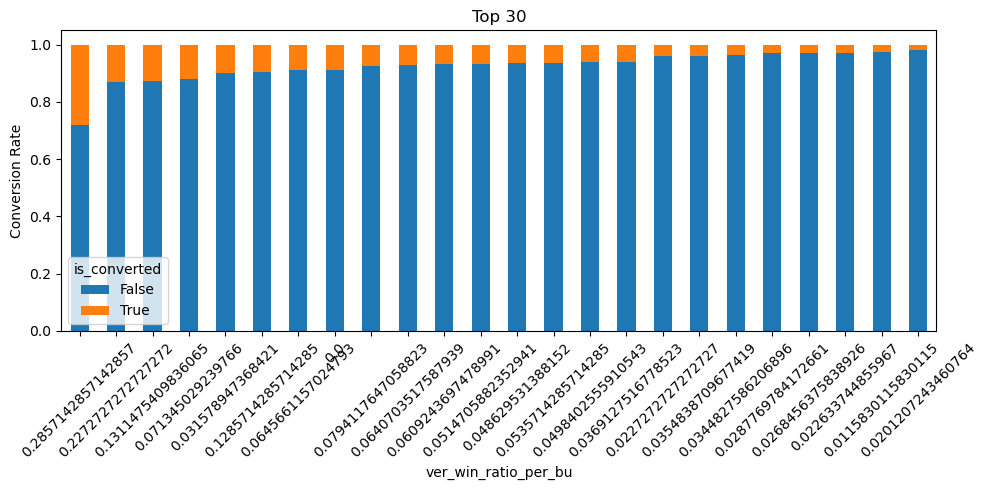

In [178]:
plot_top_conversion_rates(df_train, 'ver_win_ratio_per_bu', 'is_converted', top_n=30)

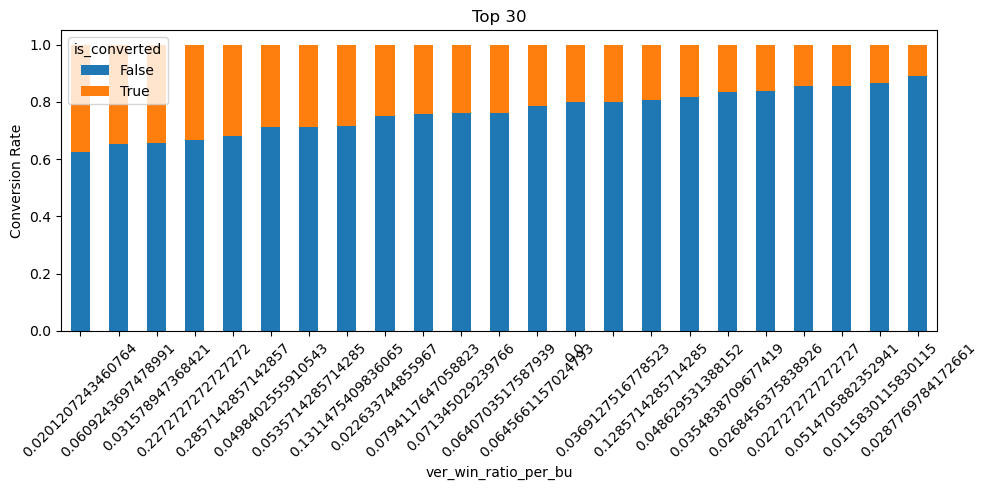

In [179]:
plot_top_conversion_rates(df_test, 'ver_win_ratio_per_bu', 'is_converted', top_n=30)

In [180]:
# business_subarea business_area 삭제할지말지 고민, . =>둘을 그룹바이 한것과 특성이 같기 떄문에

df_train.drop('business_subarea', axis=1, inplace=True)
df_test.drop('business_subarea', axis=1, inplace=True)

df_train.drop('business_area', axis=1, inplace=True)
df_test.drop('business_area', axis=1, inplace=True)

# 19. business_unit

In [181]:
print(df_train['business_unit'].isnull().sum())
print('-'*10)
print(df_test['business_unit'].isnull().sum())
print('-'*10)
print(df_train['business_unit'].value_counts())
print('-'*10)
print(df_test['business_unit'].value_counts())

0
----------
0
----------
business_unit
ID          25563
AS          24774
IT           8664
Solution      296
CM              2
Name: count, dtype: int64
----------
business_unit
AS    2410
ID    2342
IT     519
Name: count, dtype: int64


In [184]:
# CatBoost 인코딩
catboost_encoder = CatBoostEncoder()

df_train['business_unit'] = catboost_encoder.fit_transform(df_train['business_unit'], df_train['is_converted'])
df_test['business_unit'] = catboost_encoder.transform(df_test['business_unit'])

In [185]:
df_train.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'customer_position', 'response_corporate', 'expected_timeline',
       'ver_cus', 'ver_pro', 'ver_win_ratio_per_bu', 'lead_owner',
       'is_converted'],
      dtype='object')

In [186]:
df_test.columns

Index(['id', 'bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'customer_position', 'response_corporate', 'expected_timeline',
       'ver_cus', 'ver_pro', 'ver_win_ratio_per_bu', 'lead_owner',
       'is_converted'],
      dtype='object')

# 20 .enterprise
- Global 기업인지, Small/Medium 규모의 기업인지

In [187]:
print(df_train['enterprise'].isnull().sum())
print('-'*10)
print(df_test['enterprise'].isnull().sum())
print('-'*10)
print(df_train['enterprise'].value_counts())
print('-'*10)
print(df_test['enterprise'].value_counts())

0
----------
0
----------
enterprise
Enterprise    37783
SMB           21516
Name: count, dtype: int64
----------
enterprise
Enterprise    3085
SMB           2186
Name: count, dtype: int64


In [188]:
# CatBoost 인코딩
catboost_encoder = CatBoostEncoder()

df_train['enterprise'] = catboost_encoder.fit_transform(df_train['enterprise'], df_train['is_converted'])
df_test['enterprise'] = catboost_encoder.transform(df_test['enterprise'])

# 21. lead_owner
- 영업 담당자 이름  

In [189]:
print(df_train['lead_owner'].isnull().sum())
print('-'*10)
print(df_test['lead_owner'].isnull().sum())
print('-'*10)
print(df_train['lead_owner'].value_counts())
print('-'*10)
print(df_test['lead_owner'].value_counts())

0
----------
0
----------
lead_owner
174    4627
175    4120
97     2499
23     2453
194    2208
       ... 
481       1
909       1
979       1
111       1
756       1
Name: count, Length: 984, dtype: int64
----------
lead_owner
97     688
174    357
258    184
375    134
194    131
      ... 
826      1
714      1
715      1
569      1
821      1
Name: count, Length: 440, dtype: int64


In [190]:
counts = df_train['lead_owner'].value_counts()
threshold = 10
low_frequency = counts[counts < threshold].index
df_train.loc[df_train['lead_owner'].isin(low_frequency), 'lead_owner'] = 'NONE'


/var/folders/zn/z7q7zstd5jg_tg51vl5zplj80000gn/T/ipykernel_68401/3779620771.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NONE' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['lead_owner'].isin(low_frequency), 'lead_owner'] = 'NONE'


In [191]:
counts = df_test['lead_owner'].value_counts()
threshold = 10
low_frequency = counts[counts < threshold].index
df_test.loc[df_test['lead_owner'].isin(low_frequency), 'lead_owner'] = 'NONE'


/var/folders/zn/z7q7zstd5jg_tg51vl5zplj80000gn/T/ipykernel_68401/3119343594.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NONE' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test.loc[df_test['lead_owner'].isin(low_frequency), 'lead_owner'] = 'NONE'


In [192]:
# train에 없는 값이 test에 있을까? 

train_vals = set(df_train['lead_owner'].unique())
test_vals = set(df_test['lead_owner'].unique())

test_not_train = test_vals - train_vals

print(test_not_train) 

{6, 135, 1046, 670, 308, 566, 316, 317, 449, 325, 1108, 731, 348, 733, 608, 353, 999, 616, 766}


In [193]:
train_vals = set(df_train['lead_owner'].unique())
test_vals = set(df_test['lead_owner'].unique())

test_not_train = test_vals - train_vals

# df_test['customer_idx'] 열에서 test_not_train에 해당하는 값이 있는지 확인합니다.
mask = df_test['lead_owner'].isin(test_not_train)

# df_test['customer_idx'] 값이 test_not_train에 해당하는 경우에만 0으로 대체합니다.
df_test.loc[mask, 'lead_owner'] = 'NONE'

# 업데이트된 값의 개수를 출력합니다.
print(df_test['lead_owner'].value_counts())

lead_owner
NONE    1524
97       688
174      357
258      184
375      134
        ... 
146       11
49        10
223       10
245       10
838       10
Name: count, Length: 82, dtype: int64


In [194]:
train_vals = set(df_train['lead_owner'].unique())
test_vals = set(df_test['lead_owner'].unique())

test_not_train = test_vals - train_vals

print(test_not_train) 

set()


In [196]:
# TargetEncoder 적용
target_encoder = CatBoostEncoder()
df_train['lead_owner'] = target_encoder.fit_transform(df_train['lead_owner'], df_train['is_converted'])
df_test['lead_owner'] = target_encoder.transform(df_test['lead_owner'])  # 'transform'만 호출하여 새로운 데이터에 적용


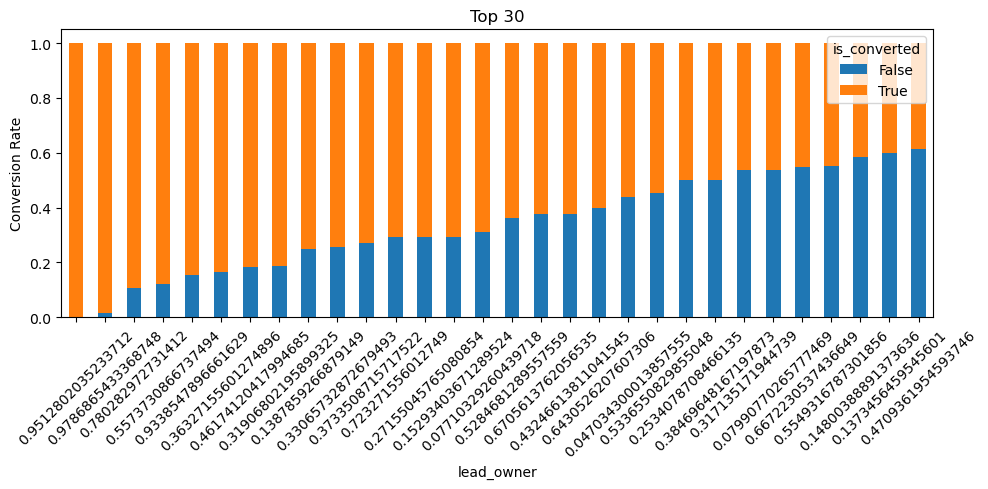

In [197]:
plot_top_conversion_rates(df_test, 'lead_owner', 'is_converted', top_n=30)

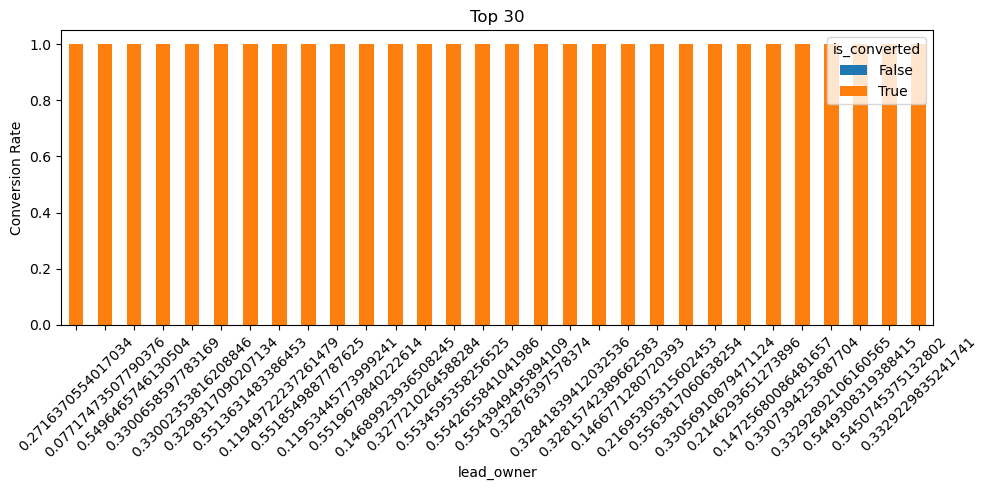

In [198]:
plot_top_conversion_rates(df_train, 'lead_owner', 'is_converted', top_n=30)

# 전처리 한 데이터 셋 저장

In [199]:
df_train.to_csv("df_train.csv")
df_test.to_csv("df_test.csv")

### 레이블 인코딩

In [200]:
df_train.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'customer_position', 'response_corporate', 'expected_timeline',
       'ver_cus', 'ver_pro', 'ver_win_ratio_per_bu', 'lead_owner',
       'is_converted'],
      dtype='object')

In [ ]:
#def label_encoding(series: pd.Series) -> pd.Series:
#    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""
#
#    my_dict = {}
#
    # 모든 요소를 문자열로 변환
#    series = series.astype(str)
#
#    for idx, value in enumerate(sorted(series.unique())):
#        my_dict[value] = idx
#    series = series.map(my_dict)
#
#    return series

In [ ]:
# 레이블 인코딩할 칼럼들
#label_columns = [
    #"customer_country",
    #"business_subarea",
    #"business_area",
    #"business_unit",
    #"customer_type",
    #"enterprise",
    #"customer_job",
    #"inquiry_type",
    #"product_category",
    #"product_subcategory",
    #"product_modelname",
    #"customer_country.1",
    #"customer_position",
    #"response_corporate",
    #"expected_timeline",
#]

#df_all = pd.concat([df_train[label_columns], df_test[label_columns]])
#
#for col in label_columns:
#    df_all[col] = label_encoding(df_all[col])

In [ ]:
#df_all

다시 학습 데이터와 제출 데이터를 분리합니다.

In [ ]:
#for col in label_columns:  
#    df_train[col] = df_all.iloc[: len(df_train)][col]
#    df_test[col] = df_all.iloc[len(df_train) :][col]

### 2-2. 학습, 검증 데이터 분리

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop("is_converted", axis=1),
    df_train["is_converted"],
    test_size=0.2,
    shuffle=True,
    random_state=684050,
)





## 3. 모델 학습

### 모델 정의 

In [ ]:
model = DecisionTreeClassifier()

### 모델 학습

In [ ]:
model.fit(x_train, y_train)

In [ ]:
# 변수 중요도 확인
feature_importances = model.feature_importances_

plt.figure(figsize=(6, 12))
plt.barh(range(x_train.shape[1]), feature_importances, align='center')
plt.yticks(range(x_train.shape[1]), x_train.columns)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Variable Importance in Decision Tree Model')
plt.show()

### 모델 성능 보기

In [ ]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [ ]:
pred = model.predict(x_val)
get_clf_eval(y_val, pred)

# 데이터 불군형으로 인한 오버샘플링

In [ ]:
df_train.isnull().sum()

In [ ]:
df_test.isnull().sum()

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# 원본 데이터를 학습 및 검증 세트로 나누기
x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop("is_converted", axis=1),
    df_train["is_converted"],
    test_size=0.2,
    shuffle=True,
    random_state=684050,
)

# SMOTE 적용 전 클래스 분포 출력
print("SMOTE 적용 전 클래스 분포:")
print(y_train.value_counts())

# SMOTE 적용
smote = SMOTE(random_state=684050)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train.fillna(0), y_train)

# SMOTE 적용 후 클래스 분포 출력
print("\nSMOTE 적용 후 클래스 분포:")
print(pd.Series(y_train_resampled).value_counts())

# 모델 정의
model = DecisionTreeClassifier()

# SMOTE 적용된 데이터로 모델 학습
model.fit(x_train_resampled, y_train_resampled)


In [ ]:
pred = model.predict(x_val.fillna(0))
get_clf_eval(y_val, pred)

In [ ]:
# 변수 중요도 확인
feature_importances = model.feature_importances_

# 변수명과 중요도를 매칭하여 출력
for feature, importance in zip(x_train.columns, feature_importances):
    print(f"{feature}: {importance:.4f}")


In [ ]:
import matplotlib.pyplot as plt

# 변수 중요도 확인
feature_importances = model.feature_importances_

# 변수명과 중요도를 매칭
features = x_train.columns
importance_dict = dict(zip(features, feature_importances))

# 중요도를 기준으로 내림차순 정렬
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
sorted_features, sorted_importances = zip(*sorted_importance)

# 시각화
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_features)), sorted_importances, align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Variable Importance in Decision Tree Model')
plt.show()


## 4. 제출하기

### 테스트 데이터 예측

In [ ]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)

In [ ]:
test_pred = model.predict(x_test.fillna(0))
sum(test_pred) # True로 예측된 개수

### 제출 파일 작성

In [ ]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**